##  Gridded Model Verification

This script verifies output from a ML-based foundation model versus a
traditional NWP system for the atmospheric system. The defaults set at the top of
this script are tailored to the Alps-Clariden HPC system at CSCS.
- The NWP-model is called COSMO-E and is initialised with the ensemble mean of the analysis. Only surface level data is available in the archive at MeteoSwiss.
- The ML-model is called Neural-LAM and is initialised with the deterministic analysis.
- The Ground Truth is the same deterministic analysis as was used to train the ML-model.
- The boundary data for both models is IFS HRES from ECMWF, where the NWP-model got 6 hourly boundary updates and the ML model 12 hourly.

For more info about the COSMO model see:
- https://www.cosmo-model.org/content/model/cosmo/coreDocumentation/cosmo_io_guide_6.00.pdf
- https://www.research-collection.ethz.ch/handle/20.500.11850/720460

In [ ]:
import random
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.diagnostics
from dask.distributed import Client, LocalCluster
from pysteps.verification.salscores import sal  # requires scikit-image
from scipy.stats import kurtosis, skew, wasserstein_distance
from scores.categorical import ThresholdEventOperator as TEO
from scores.continuous import (
    mae,
    mean_error,
    mse,
    rmse,
)
from scores.continuous.correlation import pearsonr
from scores.spatial import fss_2d

/users/sadamov/miniforge3/envs/neural-lam/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


Pysteps configuration file found at: /users/sadamov/miniforge3/envs/neural-lam/lib/python3.12/site-packages/pysteps/pystepsrc



**--------> Enter all your user settings in the cell below. <--------**

In [ ]:
### DEFAULTS ###
# This config will be applied to the data before any plotting. The data will be
# sliced and indexed according to the values in this config.The whole analysis and
# plotting will be done on the reduced data.

# IF YOUR DATA HAS DIFFERENT DIMENSIONS OR NAMES, PLEASE ADJUST THE CELLS BELOW
# MAKE SURE THE XARRAY DATASETS LOOK OKAY BEFORE RUNNING CHAPTER 1-4

# This path should point to the data that was used to train the model (default is mdp-datastore)
PATH_GROUND_TRUTH = "/iopsstor/scratch/cscs/sadamov/pyprojects_data/neural-lam/cosmo.datastore.zarr"
# This path should point to the NWP forecast data in zarr format
PATH_NWP = "/capstor/store/cscs/swissai/a01/sadamov/cosmo_e_forecast.zarr"
# This path should point to the ML forecast data in zarr format (e.g. produced by neural-lam in `eval` mode)
PATH_ML = "/iopsstor/scratch/cscs/sadamov/pyprojects_data/neural-lam/eval_results/preds_7_19_margin_interior_lr_0001_ar_12.zarr"
# This path should point to the boundary data in zarr format (default is MDP-datastore)
PATH_BOUNDARY = "/iopsstor/scratch/cscs/sadamov/pyprojects_data/neural-lam/ifs_7_19_margin_interior.datastore.zarr"

# elapsed forecast duration in steps for the forecast - [0] refers to the first forecast step at t+1
# this should be a list of integers
ELAPSED_FORECAST_DURATION = list(range(0, 120, 36))
# Select specific start_times for the forecast. This is the start and end of
# a slice in xarray. The start_time is included, the end_time is excluded.
# This should be a list of two strings in the format "YYYY-MM-DDTHH:MM:SS"
# Should be handy to evaluate certain dates, e.g. for a case study of a storm
START_TIMES = ["2019-10-31T00:00:00", "2020-10-23T13:00:00"]  # Full year
# START_TIMES = ["2020-02-08T00:00:00", "2020-02-15T00:00:00"]  # Ciara/Sabine

# Select specific plot times for the forecast (will be used to create maps for all variables)
# This only affect chapter one with the plotting of the maps
# Map creation takes a lot of time so this is limited to a single time step
# Simply rerun these cells and chapter one for more time steps
PLOT_TIME = "2020-02-13T00:00:00"

# Selection spatial grid in projection
# This is used to slice the data to a specific region
# This is in projection of the ground truth data
# The default is the whole domain [None, None]
X = [None, None]
Y = [None, None]

# Map projection settings for plotting
# This is the projection of the ground truth data
PROJECTION = ccrs.RotatedPole(
    pole_longitude=190,
    pole_latitude=43,
    central_rotated_longitude=10,
)

# Define how variables map between different data sources

# Define here which of the variables are available in the ground truth data
# The keys are the names of the variables in the ground truth data
# The values are the conventional names, used in this notebook
VARIABLES_GROUND_TRUTH = {
    # Surface and near-surface variables
    "T_2M": "temperature_2m",
    "U_10M": "wind_u_10m",
    "V_10M": "wind_v_10m",
    "PMSL": "pressure_sea_level",
    "PS": "surface_pressure",
    "TOT_PREC": "precipitation",
    "ASHFL_S": "surface_sensible_heat_flux",
    "ASOB_S": "surface_net_shortwave_radiation",
    "ATHB_S": "surface_net_longwave_radiation",
    # Upper air variables - U component
    "U_lev_6": "wind_u_level_6",
    "U_lev_12": "wind_u_level_12",
    "U_lev_20": "wind_u_level_20",
    "U_lev_27": "wind_u_level_27",
    "U_lev_31": "wind_u_level_31",
    "U_lev_39": "wind_u_level_39",
    "U_lev_45": "wind_u_level_45",
    "U_lev_60": "wind_u_level_60",
    # Upper air variables - V component
    # "V_lev_6": "wind_v_level_6",
    # "V_lev_12": "wind_v_level_12",
    # "V_lev_20": "wind_v_level_20",
    # "V_lev_27": "wind_v_level_27",
    # "V_lev_31": "wind_v_level_31",
    # "V_lev_39": "wind_v_level_39",
    # "V_lev_45": "wind_v_level_45",
    # "V_lev_60": "wind_v_level_60",
    # # Upper air variables - Pressure
    # "PP_lev_6": "pressure_level_6",
    # "PP_lev_12": "pressure_level_12",
    # "PP_lev_20": "pressure_level_20",
    # "PP_lev_27": "pressure_level_27",
    # "PP_lev_31": "pressure_level_31",
    # "PP_lev_39": "pressure_level_39",
    # "PP_lev_45": "pressure_level_45",
    # "PP_lev_60": "pressure_level_60",
    # # Upper air variables - Temperature
    # "T_lev_6": "temperature_level_6",
    # "T_lev_12": "temperature_level_12",
    # "T_lev_20": "temperature_level_20",
    # "T_lev_27": "temperature_level_27",
    # "T_lev_31": "temperature_level_31",
    # "T_lev_39": "temperature_level_39",
    # "T_lev_45": "temperature_level_45",
    # "T_lev_60": "temperature_level_60",
    # # Upper air variables - Relative Humidity
    # "RELHUM_lev_6": "relative_humidity_level_6",
    # "RELHUM_lev_12": "relative_humidity_level_12",
    # "RELHUM_lev_20": "relative_humidity_level_20",
    # "RELHUM_lev_27": "relative_humidity_level_27",
    # "RELHUM_lev_31": "relative_humidity_level_31",
    # "RELHUM_lev_39": "relative_humidity_level_39",
    # "RELHUM_lev_45": "relative_humidity_level_45",
    # "RELHUM_lev_60": "relative_humidity_level_60",
    # # Upper air variables - Vertical velocity
    # "W_lev_6": "vertical_velocity_level_6",
    # "W_lev_12": "vertical_velocity_level_12",
    # "W_lev_20": "vertical_velocity_level_20",
    # "W_lev_27": "vertical_velocity_level_27",
    # "W_lev_31": "vertical_velocity_level_31",
    # "W_lev_39": "vertical_velocity_level_39",
    # "W_lev_45": "vertical_velocity_level_45",
    # "W_lev_60": "vertical_velocity_level_60",
}

# Since the default ground_truth is the datastore that was used for model training
# the variables are identical to the VARIABLES_GROUND_TRUTH
VARIABLES_ML = VARIABLES_GROUND_TRUTH

# For the NWP-Forecast only a limited set of variables is available
# These variables are mapped to the same conventional names
# The script is flexible and will only calculate the NWP-metrics for the variables that are available
# The script will not break if some of the variables are not available
VARIABLES_NWP = {
    "wind_u_10m": "wind_u_10m",
    "wind_v_10m": "wind_v_10m",
    "precipitation_1hr": "precipitation",
    "pressure_sea_level": "pressure_sea_level",
    "surface_pressure": "surface_pressure",
    "temperature_2m": "temperature_2m",
}

# These variables are only used for chapter 1, the mapplots.
# They will be plotted for the ground truth, NWP and ML
VARIABLES_BOUNDARY = {
    # Surface and near-surface variables
    "mean_sea_level_pressure": "pressure_sea_level",
    "2m_temperature": "temperature_2m",
    "10m_u_component_of_wind": "wind_u_10m",
    "10m_v_component_of_wind": "wind_v_10m",
    "surface_pressure": "surface_pressure",
    # Upper air variables - U component
    "u_component_of_wind100hPa": "wind_u_level_6",
    "u_component_of_wind200hPa": "wind_u_level_12",
    "u_component_of_wind400hPa": "wind_u_level_20",
    "u_component_of_wind600hPa": "wind_u_level_27",
    "u_component_of_wind700hPa": "wind_u_level_31",
    "u_component_of_wind850hPa": "wind_u_level_39",
    "u_component_of_wind925hPa": "wind_u_level_45",
    "u_component_of_wind1000hPa": "wind_u_level_60",
    # Upper air variables - V component
    "v_component_of_wind100hPa": "wind_v_level_6",
    "v_component_of_wind200hPa": "wind_v_level_12",
    "v_component_of_wind400hPa": "wind_v_level_20",
    "v_component_of_wind600hPa": "wind_v_level_27",
    "v_component_of_wind700hPa": "wind_v_level_31",
    "v_component_of_wind850hPa": "wind_v_level_39",
    "v_component_of_wind925hPa": "wind_v_level_45",
    "v_component_of_wind1000hPa": "wind_v_level_60",
    # Upper air variables - Temperature
    "temperature100hPa": "temperature_level_6",
    "temperature200hPa": "temperature_level_12",
    "temperature400hPa": "temperature_level_20",
    "temperature600hPa": "temperature_level_27",
    "temperature700hPa": "temperature_level_31",
    "temperature850hPa": "temperature_level_39",
    "temperature925hPa": "temperature_level_45",
    "temperature1000hPa": "temperature_level_60",
    # Upper air variables - Vertical velocity
    "vertical_velocity100hPa": "vertical_velocity_level_6",
    "vertical_velocity200hPa": "vertical_velocity_level_12",
    "vertical_velocity400hPa": "vertical_velocity_level_20",
    "vertical_velocity600hPa": "vertical_velocity_level_27",
    "vertical_velocity700hPa": "vertical_velocity_level_31",
    "vertical_velocity850hPa": "vertical_velocity_level_39",
    "vertical_velocity925hPa": "vertical_velocity_level_45",
    "vertical_velocity1000hPa": "vertical_velocity_level_60",
}

# These variables will be used as `basename` for the vertical profiles.
# Since the input of the zarr archives is expected to have data vars that are 2D in space
# we need some base_name prefix to create the 3D variables
VARIABLES_3D = [
    "wind_u_level",
    "wind_v_level",
    "pressure_level",
    "temperature_level",
    "relative_humidity_level",
    "vertical_velocity_level",
]

# Add units dictionary after the imports
# units from zarr archives are not reliable and should rather be defined here
VARIABLE_UNITS = {
    # Surface and near-surface variables
    "temperature_2m": "K",
    "wind_u_10m": "m/s",
    "wind_v_10m": "m/s",
    "pressure_sea_level": "Pa",
    "surface_pressure": "Pa",
    "precipitation": "mm/h",
    "surface_sensible_heat_flux": "W/m²",
    "surface_net_shortwave_radiation": "W/m²",
    "surface_net_longwave_radiation": "W/m²",
    # Upper air variables
    "wind_u_level": "m/s",
    "wind_v_level": "m/s",
    "pressure_level": "hPa",
    "temperature_level": "K",
    "relative_humidity_level": "%",
    "vertical_velocity_level": "Pa/s",
}

# Define Thresholds for the ETS metric (Equitable Threat Score)
# These are calculated for wind and precipitation if available
# The score creates contingency tables for different thresholds
# The ETS is calculated for each threshold and the results are plotted
# The default thresholds are [0.1, 1, 5] for precipitation and [2.5, 5, 10] for wind
THRESHOLDS_PRECIPITATION = [0.1, 1, 5]  # mm/h
THRESHOLDS_WIND = [2.5, 5, 10]  # m/s

# Define the metrics to compute for the verification
# Some additional verifications will always be computed if the repsective vars
# are available in the data
METRICS = [
    # "MAE",
    "RMSE",
    # "MSE",
    "ME",
    "STDEV_ERR",
    "RelativeMAE",
    # "RelativeRMSE",
    # "PearsonR",
    # "Wasserstein",
]

# This setting is relevant for the mapplots in chapter 1
# Higher levels of ZOOM will zoom in on the map, cropping the boundary
ZOOM = 2  # Halves the extent of the mapplot

# For some chapters a random seed is required to reproduce the results
RANDOM_SEED = 42

# The DPI used in all plots in the notebook, export to pdf will always be 300 DPI
DPI = 100

# Subsample the data for faster plotting, 10 refers to every 10th element
# This is used to create the histograms in chapter 2 (along space and time)
# and in chapter 3 for the energy spectra (along time)
# There is a trade-off between speed and accuracy, that each user has to find
SUBSAMPLE_HISTOGRAM = 10

# Subsample the data for FSS threshold calculation, 1e7 refers to the number of elements
# This is not critical, as it is only used to calculate the 90% threshold
# for the FSS based on the ground truth data
SUBSAMPLE_FSS_THRESHOLD = 1e7

# Takes a long time, but if you see NaN in your output, you can set this to True
# This will check if there are any missing values in the data further below
# THIS NOTEBOOK WILL ONLY WORK RELIABLY IF THERE ARE NO MISSING VALUES
# If there are missing values, you have to interpolate them or remove them
CHECK_MISSING = False

# Font sizes for consistent plotting (different fig-sizes wil require different font sizes)
FONT_SIZES = {
    "axes": 13,  # Axis labels and titles
    "ticks": 13,  # Tick labels
    "legend": 13,  # Legend text
    "cbar": 13,  # Colorbar labels
    "suptitle": 15,  # Figure suptitle
    "title": 13,  # Axes titles
    "stats": 13,  # Statistics text in plots
}

In [6]:
# Create directories for plots and tables
Path("plots").mkdir(exist_ok=True)
Path("tables").mkdir(exist_ok=True)

# Colorblind-friendly color palette
COLORS = {
    "gt": "#000000",  # Black
    "ml": "#E69F00",  # Orange
    "nwp": "#56B4E9",  # Light blue
    "error": "#CC79A7",  # Pink
}

# Line styles and markers for accessibility
LINE_STYLES = {
    "gt": ("solid", "o"),
    "ml": ("dashed", "s"),
    "nwp": ("dotted", "^"),
}

# Set global font sizes
plt.rcParams.update({
    "font.size": FONT_SIZES["axes"],
    "axes.titlesize": FONT_SIZES["axes"],
    "axes.labelsize": FONT_SIZES["axes"],
    "xtick.labelsize": FONT_SIZES["ticks"],
    "ytick.labelsize": FONT_SIZES["ticks"],
    "legend.fontsize": FONT_SIZES["legend"],
    "figure.titlesize": FONT_SIZES["suptitle"],
})

# Colorblind-friendly colormap for 2D plots
COLORMAP = "viridis"

# Add level-specific units by reusing base units
required_levels = {
    int(key.split("_")[-1]) for key in VARIABLES_GROUND_TRUTH if "lev_" in key
}

# First, collect all the base variables and units we need to extend
base_level_vars = {}
for base_var, unit in VARIABLE_UNITS.items():
    if "_level" in base_var:
        base_level_vars[base_var] = unit

# Then create the level-specific entries
for level in required_levels:
    for base_var, unit in base_level_vars.items():
        VARIABLE_UNITS[f"{base_var}_{level}"] = unit


def save_plot(fig, name, time=None, remove_title=True, dpi=300):
    """Helper function to save plots consistently

    Args:
        fig: matplotlib figure object
        name (str): base name for the plot file
        time (datetime, optional): timestamp to append to filename
        remove_title (bool): remove suptitle/title hierarchically if True
        dpi (int): resolution for the saved figure, defaults to 300
    """
    if time is not None:
        name = f"{name}_{time.dt.strftime('%Y%m%d_%H').values}"

    # Sanitize filename by replacing problematic characters
    safe_name = name.replace("/", "_per_")

    # Normalize the path and ensure plots directory exists
    plot_dir = Path("plots")
    plot_dir.mkdir(exist_ok=True)

    # Remove titles if requested
    if remove_title:
        if hasattr(fig, "texts") and fig.texts:  # Check for suptitle
            fig.suptitle("")
        ax = fig.gca()
        if ax.get_title():
            ax.set_title("")

    pdf_path = plot_dir / f"{safe_name}.pdf"
    fig.savefig(pdf_path, bbox_inches="tight", dpi=dpi)


def export_table(df, name, caption=""):
    """Helper function to export tables consistently"""
    # Export to LaTeX with caption
    latex_str = df.to_latex(
        float_format="%.4f", caption=caption, label=f"tab:{name}"
    )
    with open(f"tables/{name}.tex", "w") as f:
        f.write(latex_str)

    # Export to CSV
    df.to_csv(f"tables/{name}.csv")

In [7]:
ds_ml = xr.open_zarr(PATH_ML)
ds_ml = ds_ml.sel(state_feature=list(VARIABLES_ML.keys()))
ds_ml = ds_ml.sel(y=slice(*Y), x=slice(*X))
ds_ml = ds_ml.sel(start_time=slice(*START_TIMES))
for feature in ds_ml.state_feature.values:
    ds_ml[VARIABLES_ML[feature]] = ds_ml["state"].sel(state_feature=feature)
forecast_times = (
    ds_ml.start_time.values[:, None] + ds_ml.elapsed_forecast_duration.values
)
ds_ml = ds_ml.assign_coords(
    forecast_time=(
        ("start_time", "elapsed_forecast_duration"),
        forecast_times,
    )
)
ds_ml = ds_ml.drop_vars(["state", "state_feature", "time"])
ds_ml = ds_ml.transpose("start_time", "elapsed_forecast_duration", "x", "y")
ds_ml = ds_ml[
    [
        "start_time",
        "elapsed_forecast_duration",
        "x",
        "y",
        *VARIABLES_ML.values(),
    ]
]
ds_ml = ds_ml.isel(elapsed_forecast_duration=ELAPSED_FORECAST_DURATION)

ds_ml

<xarray.Dataset> Size: 44GB
Dimensions:                          (start_time: 718,
                                      elapsed_forecast_duration: 4, x: 582,
                                      y: 390)
Coordinates:
  * start_time                       (start_time) datetime64[ns] 6kB 2019-10-...
  * elapsed_forecast_duration        (elapsed_forecast_duration) timedelta64[ns] 32B ...
  * x                                (x) int64 5kB 0 1 2 3 4 ... 578 579 580 581
  * y                                (y) int64 3kB 0 1 2 3 4 ... 386 387 388 389
    forecast_time                    (start_time, elapsed_forecast_duration) datetime64[ns] 23kB ...
Data variables: (12/17)
    temperature_2m                   (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    wind_u_10m                       (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    wind_v_10m                       (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    pressure_sea_level               (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    surface_pressure                 (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    precipitation                    (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    ...                               ...
    wind_u_level_20                  (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    wind_u_level_27                  (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    wind_u_level_31                  (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    wind_u_level_39                  (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    wind_u_level_45                  (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    wind_u_level_60                  (start_time, elapsed_forecast_duration, x, y) float32 3GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>

In [8]:
ds_gt = xr.open_zarr(PATH_GROUND_TRUTH)
ds_gt = ds_gt.set_index(grid_index=["y", "x"]).unstack("grid_index")
ds_gt = ds_gt.sel(y=slice(*Y), x=slice(*X))
ds_gt = ds_gt.sel(state_feature=list(VARIABLES_ML.keys()))
ds_gt = ds_gt.sel(split_name="test").drop_dims([
    "forcing_feature",
    "static_feature",
    "split_part",
])
for feature in ds_gt.state_feature.values:
    ds_gt[VARIABLES_ML[feature]] = ds_gt["state"].sel(state_feature=feature)
ds_gt = ds_gt.drop_vars([
    "state",
    "state_feature",
    "state_feature_units",
    "state_feature_long_name",
    "state_feature_source_dataset",
    "state__train__diff_mean",
    "state__train__diff_std",
    "state__train__mean",
    "state__train__std",
])
ds_gt = ds_gt.transpose("time", "x", "y")
ds_gt = ds_gt[
    [
        "time",
        "x",
        "y",
        *VARIABLES_GROUND_TRUTH.values(),
    ]
]
ds_gt = ds_gt.sel(time=np.unique(ds_ml.forecast_time.values.flatten()))
ds_gt


<xarray.Dataset> Size: 11GB
Dimensions:                          (time: 727, x: 582, y: 390)
Coordinates:
  * time                             (time) datetime64[ns] 6kB 2019-10-31T01:...
  * x                                (x) int64 5kB 0 1 2 3 4 ... 578 579 580 581
  * y                                (y) int64 3kB 0 1 2 3 4 ... 386 387 388 389
    split_name                       <U5 20B 'test'
    lat                              (x, y) float64 2MB dask.array<chunksize=(582, 390), meta=np.ndarray>
    lon                              (x, y) float64 2MB dask.array<chunksize=(582, 390), meta=np.ndarray>
Data variables: (12/17)
    temperature_2m                   (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    wind_u_10m                       (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    wind_v_10m                       (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    pressure_sea_level               (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    surface_pressure                 (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    precipitation                    (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    ...                               ...
    wind_u_level_20                  (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    wind_u_level_27                  (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    wind_u_level_31                  (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    wind_u_level_39                  (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    wind_u_level_45                  (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
    wind_u_level_60                  (time, x, y) float32 660MB dask.array<chunksize=(1, 582, 390), meta=np.ndarray>
Attributes:
    created_on:       2025-02-22T10:14:20
    created_with:     mllam-data-prep (https://github.com/mllam/mllam-data-prep)
    dataset_version:  v0.1.0
    mdp_version:      v0.5.0
    schema_version:   v0.6.0

In [9]:
ds_nwp = xr.open_zarr(PATH_NWP)
ds_nwp = ds_nwp.sel(y=slice(*Y), x=slice(*X), time=slice(*START_TIMES))
# The NWP data starts at elapsed forecast duration 0 = start_time
ds_nwp = ds_nwp[VARIABLES_NWP.keys()].rename(VARIABLES_NWP)
ds_nwp = ds_nwp.rename_dims({
    "lead_time": "elapsed_forecast_duration",
    "time": "start_time",
})
ds_nwp = ds_nwp.rename_vars({
    "lead_time": "elapsed_forecast_duration",
    "time": "start_time",
})
forecast_times = (
    ds_nwp.start_time.values[:, None] + ds_nwp.elapsed_forecast_duration.values
)
ds_nwp = ds_nwp.assign_coords(
    forecast_time=(
        ("start_time", "elapsed_forecast_duration"),
        forecast_times,
    )
)

# # Calculate hourly values by taking differences along elapsed_forecast_duration
ds_nwp["precipitation"] = ds_nwp.precipitation.diff(
    dim="elapsed_forecast_duration"
)
# The NWP data starts at elapsed forecast duration 0 = start_time
ds_nwp = ds_nwp.drop_isel(elapsed_forecast_duration=0).isel(
    elapsed_forecast_duration=ELAPSED_FORECAST_DURATION
)

ds_nwp = ds_nwp.transpose("start_time", "elapsed_forecast_duration", "x", "y")
ds_nwp = ds_nwp[
    [
        "start_time",
        "elapsed_forecast_duration",
        "x",
        "y",
        *VARIABLES_NWP.values(),
    ]
]

ds_nwp

/users/sadamov/miniforge3/envs/neural-lam/lib/python3.12/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


<xarray.Dataset> Size: 31GB
Dimensions:                    (start_time: 718, elapsed_forecast_duration: 4,
                                x: 582, y: 390)
Coordinates:
  * start_time                 (start_time) datetime64[ns] 6kB 2019-10-31 ......
  * elapsed_forecast_duration  (elapsed_forecast_duration) timedelta64[ns] 32B ...
  * x                          (x) int64 5kB 0 1 2 3 4 5 ... 577 578 579 580 581
  * y                          (y) int64 3kB 0 1 2 3 4 5 ... 385 386 387 388 389
    lat                        (x, y) float64 2MB dask.array<chunksize=(291, 195), meta=np.ndarray>
    lon                        (x, y) float64 2MB dask.array<chunksize=(291, 195), meta=np.ndarray>
    forecast_time              (start_time, elapsed_forecast_duration) datetime64[ns] 23kB ...
Data variables:
    wind_u_10m                 (start_time, elapsed_forecast_duration, x, y) float64 5GB dask.array<chunksize=(2, 4, 146, 98), meta=np.ndarray>
    wind_v_10m                 (start_time, elapsed_forecast_duration, x, y) float64 5GB dask.array<chunksize=(2, 4, 146, 98), meta=np.ndarray>
    precipitation              (start_time, elapsed_forecast_duration, x, y) float64 5GB dask.array<chunksize=(2, 4, 146, 98), meta=np.ndarray>
    pressure_sea_level         (start_time, elapsed_forecast_duration, x, y) float64 5GB dask.array<chunksize=(2, 4, 146, 98), meta=np.ndarray>
    surface_pressure           (start_time, elapsed_forecast_duration, x, y) float64 5GB dask.array<chunksize=(2, 4, 146, 98), meta=np.ndarray>
    temperature_2m             (start_time, elapsed_forecast_duration, x, y) float64 5GB dask.array<chunksize=(2, 4, 146, 98), meta=np.ndarray>

Check for missing data in any of the variables. If you have missing data, you need to handle it before running the verification.

In [10]:
if CHECK_MISSING:
    with LocalCluster(
        n_workers=16,
        threads_per_worker=1,
        memory_limit="16GB",
    ) as cluster:
        with Client(cluster) as client:
            missing_counts = dask.compute(
                {
                    var: ds_gt[var].isnull().sum().values
                    for var in ds_gt.data_vars
                },
                {
                    var: ds_nwp[var].isnull().sum().values
                    for var in ds_nwp.data_vars
                },
                {
                    var: ds_ml[var].isnull().sum().values
                    for var in ds_ml.data_vars
                },
            )
    # Unpack results
    gt_missing, nwp_missing, ml_missing = missing_counts

    # Print results
    print("Ground Truth")
    for var, count in gt_missing.items():
        print(f"{var}: {count} missing values")

    print("\nNWP Model")
    for var, count in nwp_missing.items():
        print(f"{var}: {count} missing values")

    print("\nML Model")
    for var, count in ml_missing.items():
        print(f"{var}: {count} missing values")

In [11]:
assert ds_gt.sizes["x"] == ds_ml.sizes["x"]
assert ds_gt.sizes["x"] == ds_nwp.sizes["x"]
assert ds_gt.sizes["y"] == ds_ml.sizes["y"]
assert ds_gt.sizes["y"] == ds_nwp.sizes["y"]
assert ds_gt.sizes["time"] == len(
    np.unique(ds_ml.forecast_time.values.flatten())
)
assert ds_gt.sizes["time"] == len(
    np.unique(ds_nwp.forecast_time.values.flatten())
)


### 1. Maps

**Random Time Selection:** A random time step is selected to avoid bias in the comparison, ensuring that the assessment is representative of typical model performance.

**Consistent Color Scales:** By setting the same minimum and maximum values across all datasets for each variable, we ensure that color differences in the plots reflect true discrepancies, not artifacts of scaling.

**Spatial Patterns:** The plots reveal how the ML model and NWP model represent geographical features like weather fronts, high and low-pressure systems, and temperature gradients. Visual comparisons can immediately highlight areas where the models perform well or poorly, guiding further investigation.

**Edge Effects:** Near the boundaries, artifacts may occur as the model does not calculate a loss in the boundary region.

In [ ]:
# Get coordinates
if hasattr(ds_gt, "longitude") and hasattr(ds_gt, "latitude"):
    lons = ds_gt.longitude.values
    lats = ds_gt.latitude.values
elif hasattr(ds_gt, "lon") and hasattr(ds_gt, "lat"):
    lons = ds_gt.lon.values
    lats = ds_gt.lat.values

lon_min = lons.min()
lon_max = lons.max()
lat_min = lats.min()
lat_max = lats.max()

# Transform domain bounds to rotated coordinates
transformer = PROJECTION.transform_points(
    ccrs.PlateCarree(),
    np.array([lon_min, lon_max]),
    np.array([lat_min, lat_max]),
)

# Get rotated coordinate bounds
rot_lon_min, rot_lon_max = transformer[:, 0].min(), transformer[:, 0].max()
rot_lat_min, rot_lat_max = transformer[:, 1].min(), transformer[:, 1].max()

In [ ]:
ds_boundary = xr.open_zarr(PATH_BOUNDARY)

temporal_dim = "time" if "time" in ds_boundary.dims else "analysis_time"
forecast_duration_dim = (
    "elapsed_forecast_duration"
    if "elapsed_forecast_duration" in ds_boundary.dims
    else None
)
dims_to_transpose = [
    dim
    for dim in [temporal_dim, forecast_duration_dim, "latitude", "longitude"]
    if dim is not None
]

ds_boundary = ds_boundary.sel(forcing_feature=list(VARIABLES_BOUNDARY.keys()))
ds_boundary = ds_boundary.sel(split_name="test").drop_dims([
    "split_part",
    "static_feature",
])
for feature in ds_boundary.forcing_feature.values:
    ds_boundary[VARIABLES_BOUNDARY[feature]] = ds_boundary["forcing"].sel(
        forcing_feature=feature
    )
ds_boundary = ds_boundary.drop_vars([
    "forcing",
    "forcing_feature",
    "forcing_feature_units",
    "forcing_feature_long_name",
    "forcing_feature_source_dataset",
    "forcing__train__diff_mean",
    "forcing__train__diff_std",
    "forcing__train__mean",
    "forcing__train__std",
])
ds_boundary = ds_boundary.set_index(grid_index=["latitude", "longitude"])
ds_boundary = ds_boundary.unstack("grid_index")
ds_boundary = ds_boundary.transpose(*dims_to_transpose)
longitude_new = np.where(
    ds_boundary["longitude"] > 180,
    ds_boundary["longitude"] - 360,
    ds_boundary["longitude"],
)
ds_boundary = ds_boundary.assign_coords(longitude=longitude_new).sortby([
    "longitude",
    "latitude",
])


lon_mesh, lat_mesh = np.meshgrid(ds_boundary.longitude, ds_boundary.latitude)
ds_boundary

In [ ]:
def create_comparison_maps(
    ds_gt,
    ds_ml,
    ds_nwp,
    ds_boundary=None,
    var=None,
    plot_time=None,
    step_size_gt=pd.Timedelta("1h"),
    random_seed=42,
    zoom_factor=None,
):
    # Handle variable selection
    variables = [var] if var else VARIABLES_GROUND_TRUTH.values()

    # Select time
    if plot_time is None:
        random.seed(random_seed)
        time_index = random.randint(0, len(ds_gt.time) - 1)
        time_selected = ds_ml.time[time_index].values
    else:
        time_selected = plot_time

    # Get number of forecast dimensions
    n_elapsed_forecast_durations = len(ds_ml.elapsed_forecast_duration)

    for var in variables:
        # Determine number of columns based on NWP data availability
        n_cols = 3 if (ds_nwp is not None and var in ds_nwp) else 2

        # Create figure with n_elapsed_forecast_durations rows and n_cols columns
        fig = plt.figure(
            figsize=(7 * n_cols, 4.5 * n_elapsed_forecast_durations), dpi=DPI
        )
        axes = np.array([
            [
                plt.subplot(
                    n_elapsed_forecast_durations,
                    n_cols,
                    i * n_cols + j + 1,
                    projection=PROJECTION,
                )
                for j in range(n_cols)
            ]
            for i in range(n_elapsed_forecast_durations)
        ])

        # Initialize arrays for global min/max
        arrays_for_minmax = []

        # First pass: collect all data for global min/max calculation
        for elapsed_forecast_dimension in ds_ml.elapsed_forecast_duration:
            # Select data for current forecast time
            ds_ml_time = ds_ml.sel(
                start_time=time_selected,
                elapsed_forecast_duration=elapsed_forecast_dimension,
            )
            ds_gt_time = ds_gt.sel(time=ds_ml_time.forecast_time)

            # Add ground truth and ML prediction to min/max arrays
            arrays_for_minmax.extend([
                ds_gt_time[var].values,
                ds_ml_time[var].values,
            ])

            # Add NWP data if available
            if ds_nwp is not None and var in ds_nwp:
                ds_nwp_time = ds_nwp.sel(
                    start_time=time_selected,
                    elapsed_forecast_duration=elapsed_forecast_dimension,
                )
                arrays_for_minmax.append(ds_nwp_time[var].values)

            # Add boundary data if available
            if ds_boundary is not None and var in ds_boundary:
                if "elapsed_forecast_duration" in ds_boundary:
                    # Determine number of steps based on time alignment
                    steps = (
                        2
                        if (
                            ds_boundary.sel(
                                analysis_time=time_selected - step_size_gt,
                                method="pad",
                            ).analysis_time.values
                            == time_selected - step_size_gt
                        )
                        else 1
                    )

                    # Get boundary data for current time
                    ds_boundary_var = ds_boundary[var].sel(
                        analysis_time=time_selected - steps * step_size_gt,
                        method="pad",
                    )
                    # Update forecast times
                    forecast_times = (
                        ds_boundary_var.analysis_time.values
                        + ds_boundary_var.elapsed_forecast_duration.values
                    )
                    ds_boundary_var["elapsed_forecast_duration"] = (
                        forecast_times
                    )
                    ds_boundary_var = ds_boundary_var.sel(
                        elapsed_forecast_duration=ds_ml_time.forecast_time,
                        method="pad",
                    )
                else:
                    ds_boundary_var = ds_boundary[var].sel(
                        time=ds_ml_time.forecast_time, method="pad"
                    )
                arrays_for_minmax.append(ds_boundary_var.values)

        # Calculate global min/max
        combined_array = np.concatenate([
            arr.flatten() for arr in arrays_for_minmax
        ])
        vmin, vmax = np.nanmin(combined_array), np.nanmax(combined_array)

        # Second pass: create plots
        for dim_idx, elapsed_forecast_dimension in enumerate(
            ds_ml.elapsed_forecast_duration
        ):
            # Select data for current forecast time
            ds_ml_time = ds_ml.sel(
                start_time=time_selected,
                elapsed_forecast_duration=elapsed_forecast_dimension,
            )
            ds_gt_time = ds_gt.sel(time=ds_ml_time.forecast_time)

            # Calculate forecast hours for titles
            forecast_hours = int(elapsed_forecast_dimension.values / 1e9 / 3600)

            # Plot boundary conditions if available
            if ds_boundary is not None and var in ds_boundary:
                if "elapsed_forecast_duration" in ds_boundary:
                    steps = (
                        2
                        if (
                            ds_boundary.sel(
                                analysis_time=time_selected - step_size_gt,
                                method="pad",
                            ).analysis_time.values
                            == time_selected - step_size_gt
                        )
                        else 1
                    )

                    ds_boundary_var = ds_boundary[var].sel(
                        analysis_time=time_selected - steps * step_size_gt,
                        method="pad",
                    )
                    forecast_times = (
                        ds_boundary_var.analysis_time.values
                        + ds_boundary_var.elapsed_forecast_duration.values
                    )
                    ds_boundary_var["elapsed_forecast_duration"] = (
                        forecast_times
                    )
                    ds_boundary_var = ds_boundary_var.sel(
                        elapsed_forecast_duration=ds_ml_time.forecast_time,
                        method="pad",
                    )
                else:
                    ds_boundary_var = ds_boundary[var].sel(
                        time=ds_ml_time.forecast_time, method="pad"
                    )

                for ax in axes[dim_idx]:
                    ax.contourf(
                        lon_mesh,
                        lat_mesh,
                        ds_boundary_var.values,
                        transform=ccrs.PlateCarree(),
                        cmap="viridis",
                        vmin=vmin,
                        vmax=vmax,
                        alpha=0.5,
                        levels=20,
                    )
                    if zoom_factor is not None:
                        set_map_extent(ax, zoom_factor, ds_boundary_var)

            # Plot ground truth
            im0 = plot_field(axes[dim_idx, 0], ds_gt_time[var], vmin, vmax)

            # Set titles
            if dim_idx == 0:
                axes[dim_idx, 0].set_title(f"Ground Truth\n+{forecast_hours}h")
                if ds_nwp is not None and var in ds_nwp:
                    axes[dim_idx, 1].set_title(f"NWP\n+{forecast_hours}h")
                    axes[dim_idx, 2].set_title(f"ML\n+{forecast_hours}h")
                else:
                    axes[dim_idx, 1].set_title(f"ML\n+{forecast_hours}h")
            else:
                axes[dim_idx, 0].set_title(f"+{forecast_hours}h")
                if ds_nwp is not None and var in ds_nwp:
                    axes[dim_idx, 1].set_title(f"+{forecast_hours}h")
                    axes[dim_idx, 2].set_title(f"+{forecast_hours}h")
                else:
                    axes[dim_idx, 1].set_title(f"+{forecast_hours}h")

            # Plot NWP and ML predictions
            col = 1
            if ds_nwp is not None and var in ds_nwp:
                ds_nwp_time = ds_nwp.sel(
                    start_time=time_selected,
                    elapsed_forecast_duration=elapsed_forecast_dimension,
                )
                plot_field(axes[dim_idx, col], ds_nwp_time[var], vmin, vmax)
                col += 1

            plot_field(axes[dim_idx, col], ds_ml_time[var], vmin, vmax)

        # Add common features and colorbar
        add_map_features(axes)
        add_colorbar(fig, im0, var)

        # Adjust layout and add title
        plt.subplots_adjust(
            top=0.92,
            bottom=0.05,
            hspace=0.2,
            wspace=0.05,
        )
        title = f"{var} starting at {str(time_selected.dt.date.values)} - {time_selected.dt.hour.values:02d} UTC"
        plt.suptitle(title, y=0.98)

        # Show and save plot
        plt.show()
        save_plot(fig, f"map_{var}_multi_efd", time_selected, dpi=DPI)
        plt.close()


def set_map_extent(ax, zoom_factor=None, boundary_data=None):
    """Set the map extent based on zoom factor and boundary data."""
    if zoom_factor is not None and boundary_data is not None:
        # Get the boundary extent
        lon = (
            boundary_data.longitude
            if hasattr(boundary_data, "longitude")
            else boundary_data.lon
        )
        lat = (
            boundary_data.latitude
            if hasattr(boundary_data, "latitude")
            else boundary_data.lat
        )

        # Calculate center
        lon_center = (lon.max() + lon.min()) / 2
        lat_center = (lat.max() + lat.min()) / 2

        # Calculate ranges
        lon_range = (lon.max() - lon.min()) / zoom_factor
        lat_range = (lat.max() - lat.min()) / zoom_factor

        # Set new extent
        ax.set_extent(
            [
                lon_center - lon_range / 2,
                lon_center + lon_range / 2,
                lat_center - lat_range / 2,
                lat_center + lat_range / 2,
            ],
            crs=ccrs.PlateCarree(),
        )


def plot_field(ax, data, vmin, vmax):
    return ax.pcolormesh(
        data.longitude if hasattr(data, "longitude") else data.lon,
        data.latitude if hasattr(data, "latitude") else data.lat,
        data.values,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
        shading="auto",
        rasterized=True,
    )


def add_map_features(axes):
    n_rows, _ = axes.shape
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            ax.coastlines(resolution="50m")
            ax.add_feature(cfeature.BORDERS, linestyle="-", alpha=0.7)
            gl = ax.gridlines(
                draw_labels=True, dms=True, x_inline=False, y_inline=False
            )

            # Turn off all labels by default
            gl.top_labels = False
            gl.bottom_labels = False
            gl.left_labels = False
            gl.right_labels = False

            # Enable left labels only for leftmost column
            if j == 0:
                gl.left_labels = True

            # Enable bottom labels only for last row
            if i == n_rows - 1:
                gl.bottom_labels = True


def add_colorbar(fig, im, var):
    cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.02])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label(VARIABLE_UNITS[var])

In [ ]:
step_size_gt = pd.Timedelta(ds_gt.time.diff("time").min().values, "h")
ds_ml = ds_ml.assign_coords({
    "lon": (("x", "y"), ds_nwp.lon.values),
    "lat": (("x", "y"), ds_nwp.lat.values),
})
if PLOT_TIME is None:
    time_selected = None
else:
    time_selected = ds_ml.sel(start_time=PLOT_TIME).start_time
create_comparison_maps(
    ds_gt=ds_gt,
    ds_ml=ds_ml,
    ds_nwp=ds_nwp,
    ds_boundary=ds_boundary,
    plot_time=time_selected,
    step_size_gt=step_size_gt,
    zoom_factor=ZOOM,
)


#### Mean Error Plot For The Same Time Step

In [ ]:
def create_error_maps(
    ds_gt,
    ds_ml,
    ds_nwp=None,
    var=None,
    plot_time=None,
    random_seed=42,
):
    """Create error maps for model outputs organized in subfigures.

    Parameters:
    -----------
    ds_gt : xarray.Dataset
        Ground truth dataset
    ds_ml : xarray.Dataset
        ML model predictions
    ds_nwp : xarray.Dataset, optional
        NWP model predictions
    var : str, optional
        Variable to plot (if None, plots all variables)
    plot_time : str, optional
        Specific time to plot (format: "YYYY-MM-DD HH:MM:SS")
    random_seed : int, default=42
        Random seed for time selection
    """
    # Handle variable selection
    variables = [var] if var else VARIABLES_GROUND_TRUTH.values()

    if plot_time is None:
        random.seed(random_seed)
        time_index = random.randint(0, len(ds_gt.time) - 1)
        time_selected = ds_ml.time[time_index].values
    else:
        time_selected = plot_time

    # Get number of forecast dimensions
    n_elapsed_forecast_durations = len(ds_ml.elapsed_forecast_duration)

    for var in variables:
        # Determine number of columns based on NWP data availability
        n_cols = 2 if (ds_nwp is not None and var in ds_nwp) else 1

        # Create figure with n_elapsed_forecast_durations rows and n_cols columns
        fig = plt.figure(
            figsize=(7 * n_cols, 4.5 * n_elapsed_forecast_durations), dpi=DPI
        )
        axes = np.array([
            [
                plt.subplot(
                    n_elapsed_forecast_durations,
                    n_cols,
                    i * n_cols + j + 1,
                    projection=PROJECTION,
                )
                for j in range(n_cols)
            ]
            for i in range(n_elapsed_forecast_durations)
        ])

        # Initialize arrays for global min/max
        arrays_for_minmax = []

        # Process each elapsed forecast dimension
        for dim_idx, elapsed_forecast_dimension in enumerate(
            ds_ml.elapsed_forecast_duration
        ):
            ds_ml_time = ds_ml.sel(
                start_time=time_selected,
                elapsed_forecast_duration=elapsed_forecast_dimension,
            )
            ds_nwp_time = (
                ds_nwp.sel(
                    start_time=time_selected,
                    elapsed_forecast_duration=elapsed_forecast_dimension,
                )
                if ds_nwp is not None
                else None
            )
            ds_gt_time = ds_gt.sel(time=ds_ml_time.forecast_time)

            # Calculate errors
            error_ml = ds_ml_time[var] - ds_gt_time[var]
            arrays_for_minmax.append(error_ml.values)

            if ds_nwp_time is not None and var in ds_nwp_time:
                error_nwp = ds_nwp_time[var] - ds_gt_time[var]
                arrays_for_minmax.append(error_nwp.values)

        # Calculate global min/max for symmetric colorbar
        max_abs_error = np.max(np.abs(arrays_for_minmax))
        vmin, vmax = -max_abs_error, max_abs_error

        # Plot for each elapsed forecast dimension
        for dim_idx, elapsed_forecast_dimension in enumerate(
            ds_ml.elapsed_forecast_duration
        ):
            ds_ml_time = ds_ml.sel(
                start_time=time_selected,
                elapsed_forecast_duration=elapsed_forecast_dimension,
            )
            ds_nwp_time = (
                ds_nwp.sel(
                    start_time=time_selected,
                    elapsed_forecast_duration=elapsed_forecast_dimension,
                )
                if ds_nwp is not None
                else None
            )
            ds_gt_time = ds_gt.sel(time=ds_ml_time.forecast_time)

            # Calculate forecast hours
            forecast_hours = int(elapsed_forecast_dimension.values / 1e9 / 3600)

            # Get coordinates
            lons = (
                ds_gt_time.longitude
                if hasattr(ds_gt_time, "longitude")
                else ds_gt_time.lon
            )
            lats = (
                ds_gt_time.latitude
                if hasattr(ds_gt_time, "latitude")
                else ds_gt_time.lat
            )

            # Plot NWP error if available
            if ds_nwp_time is not None and var in ds_nwp_time:
                error_nwp = ds_nwp_time[var] - ds_gt_time[var]
                plot_error_field(
                    axes[dim_idx, 0], lons, lats, error_nwp.values, vmin, vmax
                )
                if dim_idx == 0:
                    axes[dim_idx, 0].set_title(f"NWP Error\n+{forecast_hours}h")
                else:
                    axes[dim_idx, 0].set_title(f"+{forecast_hours}h")

            # Plot ML error
            error_ml = ds_ml_time[var] - ds_gt_time[var]
            col_idx = 1 if ds_nwp_time is not None and var in ds_nwp_time else 0
            im = plot_error_field(
                axes[dim_idx, col_idx], lons, lats, error_ml.values, vmin, vmax
            )
            if dim_idx == 0:
                axes[dim_idx, col_idx].set_title(
                    f"ML Error\n+{forecast_hours}h"
                )
            else:
                axes[dim_idx, col_idx].set_title(f"+{forecast_hours}h")

        # Add common features and colorbar
        add_map_features(axes)
        add_error_colorbar(fig, im, var)

        plt.subplots_adjust(
            top=0.9,
            bottom=0.05,
            hspace=0.2,
            wspace=0.05,
        )
        title = f"Error in {var} starting at {str(time_selected.dt.date.values)} - {time_selected.dt.hour.values:02d} UTC"
        plt.suptitle(title, y=0.98)
        plt.show()
        save_plot(fig, f"errormap_{var}_multi_efd", time_selected, dpi=DPI)
        plt.close()


def plot_error_field(ax, lons, lats, data, vmin, vmax):
    return ax.pcolormesh(
        lons,
        lats,
        data,
        transform=ccrs.PlateCarree(),
        cmap="RdBu",
        vmin=vmin,
        vmax=vmax,
        shading="auto",
        rasterized=True,
    )


def add_error_colorbar(fig, im, var):
    cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.02])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label(f"Error in {VARIABLE_UNITS[var]}")


In [ ]:
if "lon" not in ds_ml.coords:
    ds_ml = ds_ml.assign_coords({
        "lon": (("x", "y"), ds_nwp.lon.values),
        "lat": (("x", "y"), ds_nwp.lat.values),
    })
if PLOT_TIME is None:
    time_selected = None
else:
    time_selected = ds_ml.sel(start_time=PLOT_TIME).start_time
create_error_maps(
    ds_gt=ds_gt,
    ds_ml=ds_ml,
    ds_nwp=ds_nwp,
    plot_time=time_selected,
)

### 2. Histograms
By examining these distributions, we can assess whether the ML model and NWP model accurately capture the variability and frequency of different atmospheric states.

**Distribution Shape:** The histograms show whether the models replicate the skewness, kurtosis, and overall shape of the ground truth data distributions.

**Extreme Values:** Identifying how the models handle extreme conditions, such as unusually high or low temperatures, is crucial for weather prediction and risk assessment.

**Normalization Needs:** Differences in scale between variables suggest that normalization may be necessary for accurate comparisons.

In [ ]:
# Sample 10% of each dimension
ds_gt_sampled = ds_gt.isel(
    time=slice(None, None, SUBSAMPLE_HISTOGRAM),
    x=slice(None, None, SUBSAMPLE_HISTOGRAM),
    y=slice(None, None, SUBSAMPLE_HISTOGRAM),
)
ds_ml_sampled = ds_ml.isel(
    start_time=slice(None, None, SUBSAMPLE_HISTOGRAM),
    x=slice(None, None, SUBSAMPLE_HISTOGRAM),
    y=slice(None, None, SUBSAMPLE_HISTOGRAM),
)
ds_nwp_sampled = ds_nwp.isel(
    start_time=slice(None, None, SUBSAMPLE_HISTOGRAM),
    x=slice(None, None, SUBSAMPLE_HISTOGRAM),
    y=slice(None, None, SUBSAMPLE_HISTOGRAM),
)


In [ ]:
for variable_name in VARIABLES_GROUND_TRUTH.values():
    fig, ax = plt.subplots(figsize=(11, 7), dpi=DPI)

    # Convert to numpy arrays
    data_gt = ds_gt_sampled[variable_name].values.flatten()
    data_ml = ds_ml_sampled[variable_name].values.flatten()

    # Create histograms for ground truth
    ax.hist(
        data_gt,
        bins=300,
        density=True,
        color=COLORS["gt"],
        label="Ground Truth",
        histtype="stepfilled",  # Use filled steps without edges
        linewidth=0,
    )

    # Plot NWP if available
    if variable_name in ds_nwp:
        data_nwp = ds_nwp_sampled[variable_name].values.flatten()
        ax.hist(
            data_nwp,
            bins=300,
            alpha=0.8,
            density=True,
            color=COLORS["nwp"],
            label="NWP Model Prediction",
            histtype="stepfilled",
            linewidth=0,
        )

    # Create histogram for ML
    ax.hist(
        data_ml,
        bins=300,
        alpha=0.8,
        density=True,
        color=COLORS["ml"],
        label="ML Model Prediction",
        histtype="stepfilled",
        linewidth=0,
    )

    # Add labels and title with adjusted positioning
    units = VARIABLE_UNITS[variable_name]
    ax.set_title(
        f"Distribution of {variable_name}", pad=20
    )  # Add padding below title
    ax.set_xlabel(f"{units}")  # Add units to x-axis label

    # Place legend in top left with some padding from the edge
    ax.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98))

    # Adjust axis limits to leave space for both legend and table
    current_ylim = ax.get_ylim()
    ax.set_ylim(0, current_ylim[1] * 1.3)  # Increased padding for both elements

    # Calculate statistics
    stats_data = {
        "GT": [f"{skew(data_gt):.2f}", f"{kurtosis(data_gt):.2f}"],
        "ML": [f"{skew(data_ml):.2f}", f"{kurtosis(data_ml):.2f}"],
    }
    if variable_name in ds_nwp:
        stats_data["NWP"] = [
            f"{skew(data_nwp):.2f}",
            f"{kurtosis(data_nwp):.2f}",
        ]

    # Create and position table in top right with adjusted dimensions
    col_labels = ["Skewness", "Kurtosis"]
    row_labels = list(stats_data.keys())
    cell_text = [[stats_data[row][i] for i in range(2)] for row in row_labels]

    table = ax.table(
        cellText=cell_text,
        rowLabels=row_labels,
        colLabels=col_labels,
        cellLoc="center",
        loc="upper right",
        bbox=[
            0.72,
            0.78,
            0.25,
            0.18,
        ],  # Adjusted width and height [left, bottom, width, height]
    )

    # Enhanced table styling
    table.auto_set_font_size(False)
    table.set_fontsize(13)

    # Adjust column widths and row heights
    for (row, col), cell in table._cells.items():
        cell.set_text_props(wrap=True)
        cell.set_facecolor("white")
        cell.set_alpha(0.9)
        cell.set_edgecolor("#D3D3D3")  # Light gray color

        # Adjust column widths and alignment
        if col == -1:  # Row header column
            cell.set_width(0.15)
            cell.set_text_props(horizontalalignment="right")  # Right align text
        else:  # Data columns
            cell.set_width(0.12)
            cell.set_text_props(
                horizontalalignment="center"
            )  # Keep center alignment for data

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    save_plot(fig, f"histogram_{variable_name}")
    plt.close()


### 3. Energy Spectra

This chapter examines how energy is distributed across different spatial scales
in the atmosphere by computing and comparing the energy spectra of both models.
This analysis is critical in understanding the models' capabilities to simulate
atmospheric processes ranging from large-scale weather systems to small-scale
turbulence.

**FFT Computation:** The Fast Fourier Transform (FFT) is used to transform spatial data into the frequency domain, revealing how different scales contribute to the overall energy. The energy spectra are averaged over latitudes.

**Scale Representation:** The energy spectra show whether the ML model captures the correct amount of energy at various spatial scales.

**Effective Resolution:** Identifying the effective resolution helps understand the smallest scales that the model can reliably simulate.

**Numerical Artifacts:** Limitations in numerical precision can introduce artifacts in the spectra, especially at the smallest scales.

In [2]:
def calculate_energy_spectra(data):
    """Calculate the energy spectra of the given data using 2D FFT.

    Parameters
    ----------
    data : xarray.DataArray
        The data for which the energy spectra should be calculated.
        Expected dimensions must include 'x' and 'y', other dimensions will be handled automatically.

    Returns
    -------
    wavenumber : np.ndarray
        The isotropic wavenumbers.
    power : np.ndarray
        The power spectrum averaged over all non-spatial dimensions.
    effective_resolution : float
        The effective resolution of the model.
    """
    # Get grid spacing in meters
    dx = abs(float(data.x[1] - data.x[0]))
    dy = abs(float(data.y[1] - data.y[0]))

    # Identify spatial dimensions
    spatial_dims = ["y", "x"]

    # Move spatial dimensions to the end
    other_dims = [dim for dim in data.dims if dim not in spatial_dims]
    var_data = data.transpose(*other_dims, *spatial_dims).values

    # Reshape the array to combine all non-spatial dimensions
    shape = var_data.shape
    ny, nx = shape[-2:]

    if len(shape) > 2:
        var_data = var_data.reshape(-1, ny, nx)
    else:
        var_data = var_data[np.newaxis, :, :]

    # Compute 2D FFT for each sample
    fft_data = np.fft.fft2(var_data, axes=(-2, -1))
    power_spectrum = (np.abs(fft_data) ** 2).mean(
        axis=0
    )  # Average over all samples

    # Rest of the function remains the same
    # Get wavenumbers
    kx = np.fft.fftfreq(nx, d=dx)
    ky = np.fft.fftfreq(ny, d=dy)

    # Create 2D wavenumber grid
    kxx, kyy = np.meshgrid(kx, ky)
    k_mag = np.sqrt(kxx**2 + kyy**2)

    # Create wavenumber bins for azimuthal averaging
    k_bins = np.logspace(
        np.log10(k_mag[k_mag > 0].min()), np.log10(k_mag.max()), num=50
    )

    # Perform azimuthal averaging
    k_averaged = []
    power_averaged = []

    for i in range(len(k_bins) - 1):
        k_mask = (k_mag >= k_bins[i]) & (k_mag < k_bins[i + 1])
        if k_mask.any():
            k_averaged.append(np.mean(k_mag[k_mask]))
            power_averaged.append(np.mean(power_spectrum[k_mask]))

    # Convert to arrays
    k_averaged = np.array(k_averaged)
    power_averaged = np.array(power_averaged)

    # Calculate effective resolution
    effective_resolution = 1 / (4 * dx)

    # Remove first and last two wavenumbers
    return k_averaged[2:-2], power_averaged[2:-2], effective_resolution


def plot_energy_spectra(ds_gt, ds_nwp, ds_ml, var, level=None):
    """Plot energy spectra comparison with LSD metric."""
    if level is not None:
        var_data = ds_gt[var].sel(z=level)
        if var in ds_nwp:
            var_data_nwp = ds_nwp[var].sel(z=level)
        var_data_ml = ds_ml[var].sel(z=level)
    else:
        var_data = ds_gt[var]
        if var in ds_nwp:
            var_data_nwp = ds_nwp[var]
        var_data_ml = ds_ml[var]

    # Calculate energy spectra
    wavenumber_gt, spectrum_gt, effective_resolution = calculate_energy_spectra(
        var_data
    )
    if var in ds_nwp:
        wavenumber_nwp, spectrum_nwp, _ = calculate_energy_spectra(var_data_nwp)
    else:
        spectrum_nwp = None
    wavenumber_ml, spectrum_ml, _ = calculate_energy_spectra(var_data_ml)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

    # Plot spectra
    ax.loglog(
        wavenumber_gt,
        spectrum_gt,
        color=COLORS["gt"],
        label="Ground Truth",
        linestyle=LINE_STYLES["gt"][0],
        marker=LINE_STYLES["gt"][1],
        markevery=5,
    )  # Add markers every 5 points for clarity

    if var in ds_nwp:
        ax.loglog(
            wavenumber_nwp,
            spectrum_nwp,
            color=COLORS["nwp"],
            label="NWP Model Prediction",
            linestyle=LINE_STYLES["nwp"][0],
            marker=LINE_STYLES["nwp"][1],
            markevery=3,
        )

    ax.loglog(
        wavenumber_ml,
        spectrum_ml,
        color=COLORS["ml"],
        label="ML Model Prediction",
        linestyle=LINE_STYLES["ml"][0],
        marker=LINE_STYLES["ml"][1],
        markevery=4,
    )

    # Plot effective resolution
    ax.axvline(
        effective_resolution,
        color="salmon",
        linestyle="--",
        label="Effective Model Resolution",
    )

    # Add LSD metric
    add_lsd_to_plot(ax, spectrum_gt, spectrum_nwp, spectrum_ml)

    # Customize plot
    ax.set_xlabel("Wavenumber [1/m]")
    unit = VARIABLE_UNITS.get(var, "")
    ax.set_ylabel(f"Power Spectral Density [({unit})² * m⁻¹]")
    title = f"Energy Spectra Comparison for {var}"
    if level is not None:
        title += f" at Level {level} hPa"
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--", alpha=0.5)

    # Save plot
    plot_name = f"energy_spectra_{var}"
    if level is not None:
        plot_name += f"_level_{level}"
    plt.tight_layout()
    plt.show()
    save_plot(fig, plot_name)
    plt.close()


def calculate_log_spectral_distance(true_spectrum, nwp_spectrum, ml_spectrum):
    """
    Calculate the Log Spectral Distance between three power spectra
    """
    eps = 1e-10
    log_spec1 = np.log10(true_spectrum + eps)
    log_spec3 = np.log10(ml_spectrum + eps)
    lsd_ml = np.sqrt(np.mean((log_spec1 - log_spec3) ** 2))
    if nwp_spectrum is None:
        return None, lsd_ml
    log_spec2 = np.log10(nwp_spectrum + eps)
    lsd_nwp = np.sqrt(np.mean((log_spec1 - log_spec2) ** 2))
    return lsd_nwp, lsd_ml


def add_lsd_to_plot(ax, true_spectrum, nwp_spectrum, ml_spectrum):
    """
    Add LSD metric as text box to spectrum plot
    """
    if nwp_spectrum is None:
        lsd_nwp = None
        _, lsd_ml = calculate_log_spectral_distance(
            true_spectrum, None, ml_spectrum
        )
        textstr = f"LSD ML = {lsd_ml:.4f}"
    else:
        lsd_nwp, lsd_ml = calculate_log_spectral_distance(
            true_spectrum, nwp_spectrum, ml_spectrum
        )
        textstr = f"LSD NWP = {lsd_nwp:.4f}, LSD ML = {lsd_ml:.4f}"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    ax.text(
        0.4,
        0.07,
        textstr,
        transform=ax.transAxes,
        verticalalignment="top",
        bbox=props,
    )

To interpret the Log-Spectral Distance (LSD) metric:
The LSD quantifies the difference between two spectra, with lower values indicating better similarity (area between the two spectra). 

Lower values indicate better similarity between spectra
- LSD = 0 means identical spectra

Typical values depend on the specific application, but generally:
- LSD < 1: Good similarity
- 1 < LSD < 2: Moderate differences
- LSD > 2: Significant differences

In [ ]:
with LocalCluster(
    n_workers=16,
    threads_per_worker=1,
    memory_limit="16GB",
) as cluster:
    with Client(cluster) as client:
        for var in VARIABLES_GROUND_TRUTH.values():
            plot_energy_spectra(
                ds_gt.isel(time=slice(None, None, SUBSAMPLE_HISTOGRAM)),
                ds_nwp.isel(start_time=slice(None, None, SUBSAMPLE_HISTOGRAM)),
                ds_ml.isel(start_time=slice(None, None, SUBSAMPLE_HISTOGRAM)),
                var,
            )

In [ ]:
def display_and_export_lsd_table(
    ds_gt, ds_ml, ds_nwp, variables, name, caption=""
):
    """
    Display and export a table with LSD metrics for variables as rows and ML/NWP as columns.
    Handles missing variables in NWP dataset gracefully.

    Args:
        ds_gt, ds_ml, ds_nwp: Input datasets
        variables: Variables to analyze
        name: Name for the exported files
        caption: Caption for the LaTeX table
    """
    # Initialize data dictionary with ML and NWP columns
    lsd_data = {var: {"ML": None, "NWP": None} for var in variables}

    for var in variables:
        # Skip if variable not in ground truth
        if var not in ds_gt:
            continue

        var_data_gt = ds_gt[var]

        # Calculate ML metrics if variable exists in ML data
        if var in ds_ml:
            var_data_ml = ds_ml[var]
            _, spectrum_gt, _ = calculate_energy_spectra(var_data_gt)
            _, spectrum_ml, _ = calculate_energy_spectra(var_data_ml)
            _, lsd_ml = calculate_log_spectral_distance(
                spectrum_gt, None, spectrum_ml
            )
            lsd_data[var]["ML"] = lsd_ml

        # Calculate NWP metrics if variable exists in NWP data
        if var in ds_nwp:
            var_data_nwp = ds_nwp[var]
            # Recalculate ground truth spectrum only if not done for ML
            if var not in ds_ml:
                _, spectrum_gt, _ = calculate_energy_spectra(var_data_gt)
            _, spectrum_nwp, _ = calculate_energy_spectra(var_data_nwp)
            _, lsd_nwp = calculate_log_spectral_distance(
                spectrum_gt, None, spectrum_nwp
            )
            lsd_data[var]["NWP"] = lsd_nwp

    df = pd.DataFrame(lsd_data).T

    # Display styled table
    styled_df = df.style.format(
        lambda x: f"{x:.3f}" if pd.notnull(x) else "-"
    ).map(
        lambda x: f"color: {'green' if x < 1 else 'orange' if x < 2 else 'red'}"
        if pd.notnull(x)
        else ""
    )
    display(styled_df)

    # Export raw dataframe
    export_table(df, name, caption)


with LocalCluster(
    n_workers=16,
    threads_per_worker=1,
    memory_limit="16GB",
) as cluster:
    with Client(cluster) as client:
        display_and_export_lsd_table(
            ds_gt.isel(time=slice(None, None, SUBSAMPLE_HISTOGRAM)),
            ds_ml.isel(start_time=slice(None, None, SUBSAMPLE_HISTOGRAM)),
            ds_nwp.isel(start_time=slice(None, None, SUBSAMPLE_HISTOGRAM)),
            VARIABLES_GROUND_TRUTH.values(),
            name="lsd_metrics",
            caption="Log Spectral Distance (LSD) metrics comparison between ML and NWP models",
        )


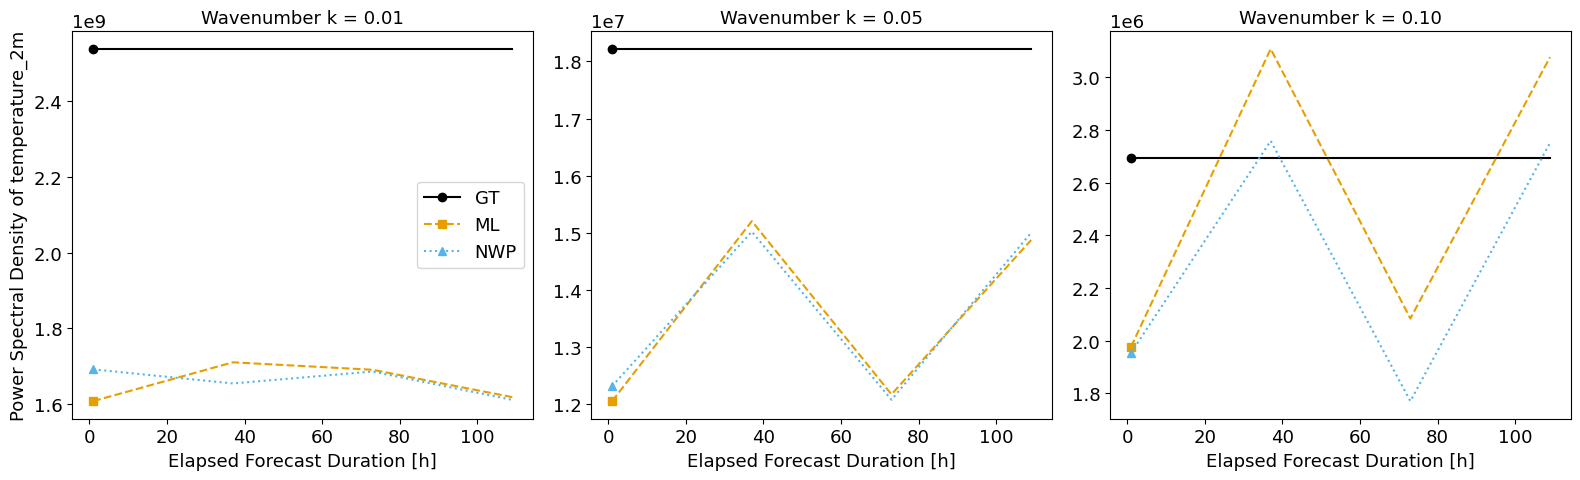

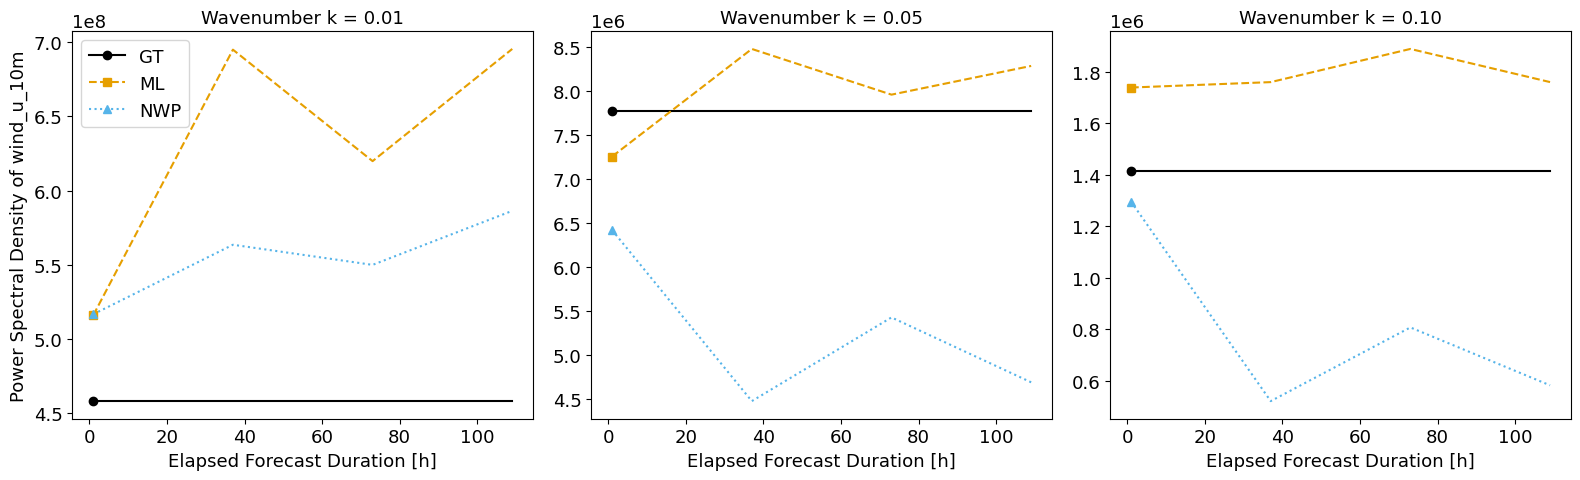

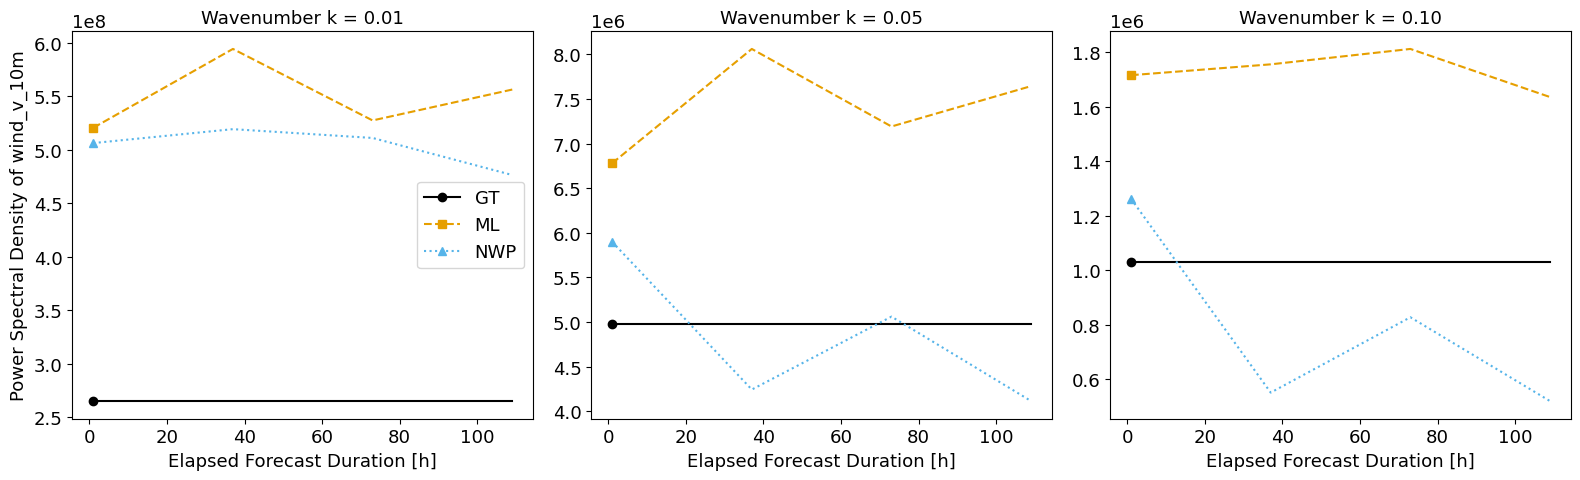

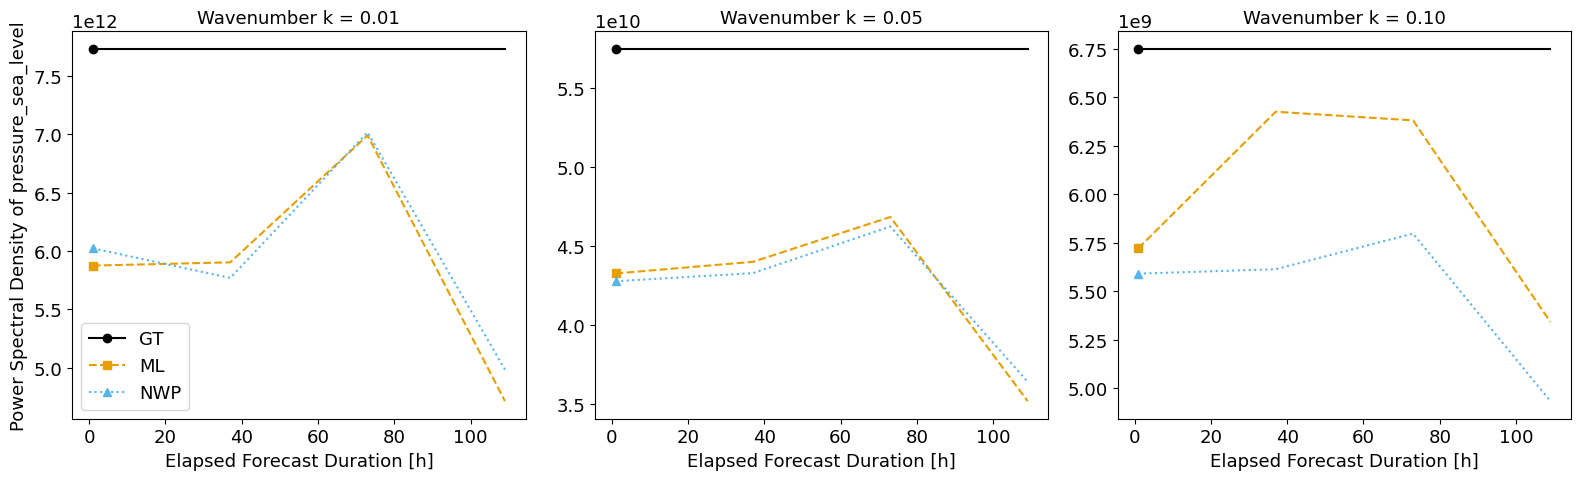

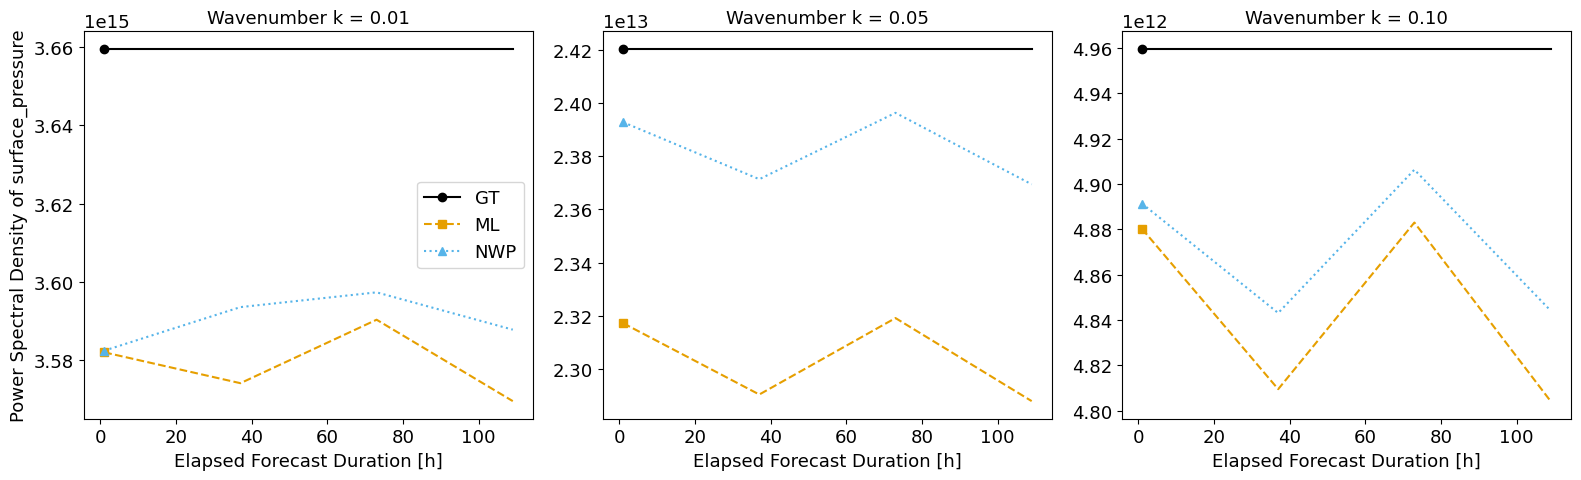

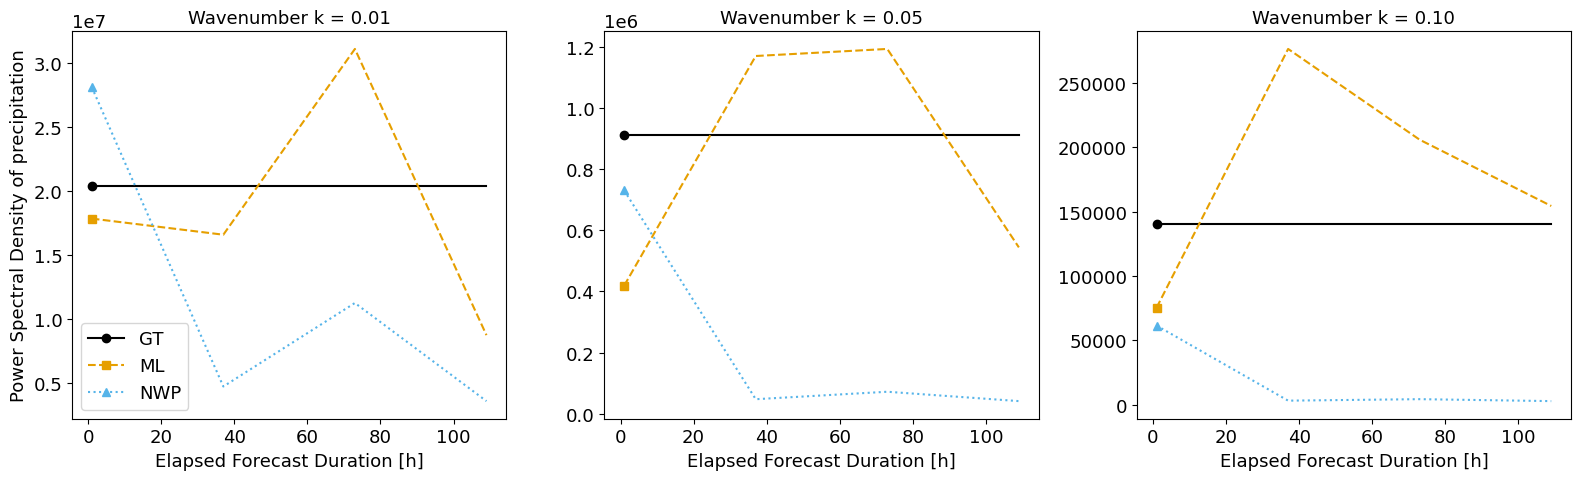

In [ ]:
def plot_wavenumber_evolution(
    ds_gt, ds_ml, ds_nwp, variables, wavenumbers=[1e-2, 5e-2, 1e-1], level=None
):
    for var in variables:
        # Skip if variable not in ground truth
        if var not in ds_gt:
            continue

        # Skip if variable not in ML dataset
        if var not in ds_ml:
            continue

        fig, axes = plt.subplots(1, len(wavenumbers), figsize=(16, 5), dpi=DPI)
        forecast_times = ds_ml.elapsed_forecast_duration.values

        for idx, target_k in enumerate(wavenumbers):
            spectra = {
                "gt": [],
                "ml": [],
                "nwp": [] if (ds_nwp is not None and var in ds_nwp) else None,
            }

            # Calculate GT spectrum once
            if level is not None:
                gt_data = ds_gt[var].sel(z=level)
            else:
                gt_data = ds_gt[var]
            k, gt_spec, _ = calculate_energy_spectra(gt_data.isel(time=0))
            idx_k = np.abs(k - target_k).argmin()
            gt_power = gt_spec[idx_k]

            for time in forecast_times:
                # Handle ML and NWP data
                data = {}
                for key, ds in zip(["ml", "nwp"], [ds_ml, ds_nwp]):
                    # Skip if dataset is None or variable not in NWP
                    if ds is None or (key == "nwp" and var not in ds):
                        continue

                    if level is not None:
                        data[key] = ds[var].sel(
                            elapsed_forecast_duration=time, z=level
                        )
                    else:
                        data[key] = ds[var].sel(elapsed_forecast_duration=time)

                    k, spec, _ = calculate_energy_spectra(data[key])
                    idx_k = np.abs(k - target_k).argmin()
                    spectra[key].append(spec[idx_k])
                spectra["gt"].append(gt_power)

            # Plot evolution for current wavenumber
            hours = forecast_times / np.timedelta64(1, "h")

            export_table(
                pd.DataFrame(
                    {
                        key.upper(): values
                        for key, values in spectra.items()
                        if values
                    },
                    index=hours,
                ).rename_axis(
                    index="Elapsed Forecast Duration [h]",
                    columns=f"Power Spectral Density (k={target_k:.2e})",
                ),
                f"wavenumber_evolution_{var}_k{target_k:.2e}",
            )

            for key, values in spectra.items():
                if not values:
                    continue

                axes[idx].plot(
                    hours,
                    values,
                    color=COLORS[key],
                    linestyle=LINE_STYLES[key][0],
                    marker=LINE_STYLES[key][1],
                    label=key.upper(),
                    markevery=5,
                )

            # Add titles and labels
            axes[idx].set_title(f"Wavenumber k = {target_k:.2f}")
            axes[idx].set_xlabel("Elapsed Forecast Duration [h]")
            if idx == 0:
                axes[idx].set_ylabel(f"Power Spectral Density of {var}")
                axes[idx].legend()

        plt.tight_layout()
        save_plot(fig, f"wavenumber_evolution_{var}", remove_title=False)


with LocalCluster(
    n_workers=16,
    threads_per_worker=1,
    memory_limit="16GB",
) as cluster:
    with Client(cluster) as client:
        plot_wavenumber_evolution(
            ds_gt.isel(time=slice(None, None, SUBSAMPLE_HISTOGRAM)),
            ds_nwp.isel(start_time=slice(None, None, SUBSAMPLE_HISTOGRAM)),
            ds_ml.isel(start_time=slice(None, None, SUBSAMPLE_HISTOGRAM)),
            variables=VARIABLES_GROUND_TRUTH.values(),
        )

### 4. Vertical Profiles
In this chapter, the focus is on assessing how the relative error between the ML
model and ground truth data.
Vertical profiles are essential for understanding the atmospheric structure and
processes at different pressure levels. Obviously these plots only work for 3D
variables.

**Relative Error Calculation:** Using percentage differences provides a
normalized measure of error that is comparable across variables and vertical
levels.

**Altitude-Specific Insights:** The plots reveal whether the ML model performs
consistently across different altitudes or if certain layers pose challenges.

**Atmospheric Dynamics:** Accurate representation of vertical profiles is
crucial for modeling phenomena like convection or jet stream anomalies.

**Pressure Level Interpretation:** Lower vertical levels correspond to higher
altitudes. Inverted axes help represent this correctly but can be
counterintuitive.

In [ ]:
def plot_vertical_errors(ds_gt, ds_ml, variables):
    """
    Plot vertical profiles of relative error for each variable separately.
    Variables with same prefix are stacked along level dimension.
    Shows separate lines for each forecast duration.
    """
    LINESTYLES = [
        "-",
        "--",
        ":",
        "-.",
        (0, (3, 1, 1, 1)),
        (0, (3, 1, 1, 1, 1, 1)),
    ]

    # Group variables by their prefix (without level)
    var_groups = {}

    for var in variables.values():
        if any(var.startswith(v) for v in VARIABLES_3D):
            base_name = "_".join(var.split("_")[:-2])
            level = int(var.split("_")[-1])

            if base_name not in var_groups:
                var_groups[base_name] = {"vars": [], "levels": []}
            var_groups[base_name]["vars"].append(var)
            var_groups[base_name]["levels"].append(level)
            var_groups[base_name]["unit"] = VARIABLE_UNITS[var]

    if len(var_groups) == 0:
        print("No 3D variables found in the dataset.")
        return

    epsilon = 1e-6

    # Plot each variable separately
    for base_name, group in var_groups.items():
        # Create new figure for each variable
        fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)

        # Sort by level to ensure correct ordering
        sorted_idx = np.argsort(group["levels"])
        sorted_vars = [group["vars"][i] for i in sorted_idx]
        sorted_levels = [group["levels"][i] for i in sorted_idx]

        # Get unique forecast durations
        unique_durations = np.unique([
            match["ml_duration_idx"] for match in matched_indices
        ])

        for dur_idx in unique_durations:
            # Filter matches for this duration
            dur_matches = [
                m for m in matched_indices if m["ml_duration_idx"] == dur_idx
            ]
            dur_times = ds_gt_times[[m["gt_idx"] for m in dur_matches]]

            # Stack variables for this duration
            stacked_gt = xr.concat(
                [ds_gt.sel(time=dur_times)[var] for var in sorted_vars],
                dim=pd.Index(sorted_levels, name="level"),
            )

            # Create ML data for this duration
            ml_data = {}
            for var in sorted_vars:
                matched_data = np.zeros((
                    len(dur_matches),
                    ds_ml.x.size,
                    ds_ml.y.size,
                ))
                for j, match in enumerate(dur_matches):
                    matched_data[j] = (
                        ds_ml[var]
                        .isel(
                            start_time=match["ml_start_time_idx"],
                            elapsed_forecast_duration=match["ml_duration_idx"],
                        )
                        .values
                    )
                ml_data[var] = (("time", "x", "y"), matched_data)

            ds_ml_dur = xr.Dataset(
                data_vars=ml_data,
                coords={"time": dur_times, "x": ds_ml.x, "y": ds_ml.y},
            )

            stacked_ml = xr.concat(
                [ds_ml_dur[var] for var in sorted_vars],
                dim=pd.Index(sorted_levels, name="level"),
            )

            # Calculate relative error for this duration
            relative_error = (
                abs(stacked_ml - stacked_gt) / abs(stacked_gt + epsilon)
            ).mean(dim=["time", "y", "x"]) * 100

            # Plot with different color for each duration
            dur_hours = (
                ds_ml.elapsed_forecast_duration.values[dur_idx]
                .astype("timedelta64[h]")
                .astype(int)
            )
            ax.plot(
                relative_error,
                relative_error.level,
                linewidth=2,
                linestyle=LINESTYLES[dur_idx % len(LINESTYLES)],
                label=f"Forecast +{dur_hours}h",
            )

        unit = group["unit"][0]
        ax.set_title(f"Relative Error for {base_name} [{unit}]")
        ax.set_xlabel("Relative Error (%)")
        ax.set_ylabel("Vertical Level")
        ax.grid(True, alpha=0.3)
        ax.invert_yaxis()
        ax.legend()

        plt.tight_layout()
        plt.show()
        save_plot(fig, f"vertical_profile_{base_name}")
        plt.close()


# Create a mapping of all forecast times between ds_ml and ds_gt
ds_ml_times = ds_ml.forecast_time.values.ravel()  # Flatten the forecast times
ds_gt_times = ds_gt.time.values

# Find exact matches between ML forecast times and ground truth times
matched_indices = []
for gt_idx, gt_time in enumerate(ds_gt_times):
    # Find exact matches
    ml_matches = np.where(ds_ml_times == gt_time)[0]

    for ml_idx in ml_matches:
        # Convert flat index to 2D indices
        start_idx = ml_idx // len(ds_ml.elapsed_forecast_duration)
        duration_idx = ml_idx % len(ds_ml.elapsed_forecast_duration)

        matched_indices.append({
            "gt_idx": gt_idx,
            "ml_start_time_idx": start_idx,
            "ml_duration_idx": duration_idx,
        })

with LocalCluster(
    n_workers=16,
    threads_per_worker=1,
    memory_limit="16GB",
) as cluster:
    with Client(cluster) as client:
        plot_vertical_errors(
            ds_gt,
            ds_ml,
            VARIABLES_GROUND_TRUTH,
        )


### 5. Various Verification Metrics
The final chapter consolidates various statistical metrics to provide a broad
evaluation of the ML model's performance. By considering multiple metrics, we
gain a nuanced understanding of both the strengths and weaknesses of the model.

**Metric Diversity:** Including MAE, RMSE, MSE, Pearson correlation, and the
Fractions Skill Score (FSS) covers different aspects of model performance, from
average errors to spatial pattern accuracy.

**ME** (Mean Error): Indicates the average discrepancy between the model and ground truth values. A positive value indicates that the model tends to overestimate, while a negative value suggests underestimation. Also called Bias.

**STDEV-ERR** (Standard Deviation of Errors): Shows the variability of errors, highlighting whether the model is consistent in its predictions.

**MAE, MSE and RMSE:** Offer insights into the average magnitude of errors, with
RMSE emphasizing larger discrepancies. The colors indicating high errors are
only implemented for these three metrics with standardization.

**Pearson Correlation:** Assesses the linear relationship, indicating whether
the model captures variability even if biases exist.

**FSS:** Evaluates spatial accuracy, which is particularly important for
predicting localized weather events.

**Wasserstein Distance:** Provides a holistic view of distributional similarity
across variables. Same as chapter 3.

**Holistic Assessment:** The combination of metrics provides a comprehensive
performance profile, essential for model validation and comparison. More complex metrics are explained in more detail.

#### Fractional Skill Score
Range: 0 to 1, where:
- 1 = perfect score
- 0 = no skill compared to random chance

**Key Properties:**
- FSS measures the spatial agreement between two fields, accounting for the spatial scale of the features
- It's particularly useful for assessing the spatial distribution of precipitation, cloud cover, or other fields with spatial structure

**Advantages:**
- More meaningful than simple correlation for spatial fields
- Accounts for the spatial scale of features
- Provides a single value for the entire field comparison

In [ ]:
# These helper functions are only used to calculate the FSS threshold
max_spatial_dim = np.maximum(ds_gt.x.size, ds_gt.y.size)
window_size = (max_spatial_dim // 100,) * 2
n_points = int(
    np.minimum(
        SUBSAMPLE_FSS_THRESHOLD,
        ds_ml[list(VARIABLES_GROUND_TRUTH.values())[0]]
        .isel(elapsed_forecast_duration=0)
        .size,
    )
)
print(f"Using window size for FSS: {window_size}")
print(f"Using n_points for FSS: {n_points}")

In [ ]:
def calculate_metrics_by_efd(
    ds_gt,
    ds_nwp=None,
    ds_ml=None,
    metrics_to_compute=None,
    subsample_points=1e7,
    window_size=3,
    prefix="metrics",
):
    """Calculate metrics for each Elapsed Forecast Duration for gridded data."""
    if isinstance(window_size, (int, float)):
        window_size = (int(window_size), int(window_size))

    if metrics_to_compute is None:
        metrics_to_compute = METRICS

    variables = list(ds_gt.data_vars)
    elapsed_forecast_durations = ds_ml.elapsed_forecast_duration
    elapsed_forecast_durations_hours = elapsed_forecast_durations.values.astype(
        "timedelta64[s]"
    ) / np.timedelta64(1, "h")

    metrics_by_efd = {}
    combined_metrics = {}

    for efd, lt_hours in zip(
        elapsed_forecast_durations, elapsed_forecast_durations_hours
    ):
        print(
            f"\nCalculating metrics for elapsed forecast duration: {lt_hours.item():.1f}h"
        )

        ds_ml_lead = ds_ml.sel(elapsed_forecast_duration=efd)
        if ds_nwp is not None:
            ds_nwp_lead = ds_nwp.sel(elapsed_forecast_duration=efd)

        forecast_times = ds_ml_lead.forecast_time.values.flatten()
        ds_gt_lead = ds_gt.sel(time=forecast_times)
        metrics_dict = {}

        for var in variables:
            print(f"Processing {var}")

            # Get data as xarray DataArrays
            y_true = ds_gt_lead[var]
            y_pred_ml = ds_ml_lead[var]

            # Create masks for each dataset
            mask_true = xr.where(~np.isnan(y_true), True, False)
            mask_ml = xr.where(~np.isnan(y_pred_ml), True, False)

            if ds_nwp is not None and var in ds_nwp:
                y_pred_nwp = ds_nwp_lead[var]
                mask_nwp = xr.where(~np.isnan(y_pred_nwp), True, False)
                valid_mask = mask_true & mask_ml & mask_nwp
            else:
                valid_mask = mask_true & mask_ml

            y_true = y_true.where(valid_mask)
            y_pred_ml = y_pred_ml.where(valid_mask)
            if ds_nwp is not None and var in ds_nwp:
                y_pred_nwp = y_pred_nwp.where(valid_mask)

            # Calculate quantile for FSS
            sample = np.random.choice(
                y_true.values.ravel(),
                int(min(subsample_points, y_true.size)),
                replace=False,
            )
            quantile_90 = np.quantile(sample, 0.90)

            metrics_dict[var] = {}

            # Calculate ML metrics
            if "MAE" in metrics_to_compute:
                metrics_dict[var]["MAE ML"] = mae(y_pred_ml, y_true).values
            if "RMSE" in metrics_to_compute:
                metrics_dict[var]["RMSE ML"] = rmse(y_pred_ml, y_true).values
            if "MSE" in metrics_to_compute:
                metrics_dict[var]["MSE ML"] = mse(y_pred_ml, y_true).values
            if "ME" in metrics_to_compute:
                metrics_dict[var]["ME ML"] = mean_error(
                    y_pred_ml, y_true
                ).values
            if "STDEV_ERR" in metrics_to_compute:
                metrics_dict[var]["STDEV_ERR ML"] = (
                    (y_pred_ml - y_true).std().values
                )
            if "RelativeMAE" in metrics_to_compute:
                rel_mae = (
                    abs(y_pred_ml - y_true) / (abs(y_true) + 1e-6)
                ).mean()
                metrics_dict[var]["RelativeMAE ML"] = rel_mae.values
            if "RelativeRMSE" in metrics_to_compute:
                rel_rmse = np.sqrt(
                    ((y_pred_ml - y_true) ** 2 / (y_true**2 + 1e-6)).mean()
                )
                metrics_dict[var]["RelativeRMSE ML"] = rel_rmse.values
            if "PearsonR" in metrics_to_compute:
                metrics_dict[var]["PearsonR ML"] = pearsonr(
                    y_pred_ml, y_true
                ).values
            if "FSS" in metrics_to_compute:
                metrics_dict[var]["FSS ML"] = fss_2d(
                    y_pred_ml,
                    y_true,
                    event_threshold=quantile_90,
                    window_size=window_size,
                    spatial_dims=["y", "x"],
                ).values
            if "Wasserstein" in metrics_to_compute:
                pred_vals = y_pred_ml.values[valid_mask.values]
                true_vals = y_true.values[valid_mask.values]
                metrics_dict[var]["Wasserstein ML"] = wasserstein_distance(
                    pred_vals, true_vals
                )

            # Calculate NWP metrics if available
            if ds_nwp is not None and var in ds_nwp:
                if "MAE" in metrics_to_compute:
                    metrics_dict[var]["MAE NWP"] = mae(
                        y_pred_nwp, y_true
                    ).values
                if "RMSE" in metrics_to_compute:
                    metrics_dict[var]["RMSE NWP"] = rmse(
                        y_pred_nwp, y_true
                    ).values
                if "MSE" in metrics_to_compute:
                    metrics_dict[var]["MSE NWP"] = mse(
                        y_pred_nwp, y_true
                    ).values
                if "ME" in metrics_to_compute:
                    metrics_dict[var]["ME NWP"] = mean_error(
                        y_pred_nwp, y_true
                    ).values
                if "STDEV_ERR" in metrics_to_compute:
                    metrics_dict[var]["STDEV_ERR NWP"] = (
                        (y_pred_nwp - y_true).std().values
                    )
                if "RelativeMAE" in metrics_to_compute:
                    rel_mae = (
                        abs(y_pred_nwp - y_true) / (abs(y_true) + 1e-6)
                    ).mean()
                    metrics_dict[var]["RelativeMAE NWP"] = rel_mae.values
                if "RelativeRMSE" in metrics_to_compute:
                    rel_rmse = np.sqrt(
                        ((y_pred_nwp - y_true) ** 2 / (y_true**2 + 1e-6)).mean()
                    )
                    metrics_dict[var]["RelativeRMSE NWP"] = rel_rmse.values
                if "PearsonR" in metrics_to_compute:
                    metrics_dict[var]["PearsonR NWP"] = pearsonr(
                        y_pred_nwp, y_true
                    ).values
                if "FSS" in metrics_to_compute:
                    metrics_dict[var]["FSS NWP"] = fss_2d(
                        y_pred_nwp,
                        y_true,
                        event_threshold=quantile_90,
                        window_size=window_size,
                        spatial_dims=["y", "x"],
                    ).values
                if "Wasserstein" in metrics_to_compute:
                    pred_vals = y_pred_nwp.values[valid_mask.values]
                    true_vals = y_true.values[valid_mask.values]
                    metrics_dict[var]["Wasserstein NWP"] = wasserstein_distance(
                        pred_vals, true_vals
                    )

            # Store combined metrics
            for metric_name, value in metrics_dict[var].items():
                key = f"{var}_{metric_name}"
                if key not in combined_metrics:
                    combined_metrics[key] = []
                combined_metrics[key].append(value)

        metrics_by_efd[lt_hours.item()] = pd.DataFrame.from_dict(
            metrics_dict, orient="index"
        )

    # Create combined metrics DataFrame
    elapsed_forecast_durations_hours_float = [
        x.item() for x in elapsed_forecast_durations_hours
    ]
    combined_df = pd.DataFrame(
        combined_metrics, index=elapsed_forecast_durations_hours_float
    )
    combined_df.index.name = "Forecast Hours"

    export_table(combined_df, f"{prefix}", "Combined metrics")

    return metrics_by_efd, combined_df


In [ ]:
with LocalCluster(
    n_workers=16,
    threads_per_worker=1,
    memory_limit="16GB",
) as cluster:
    with Client(cluster) as client:
        metrics_by_efd = calculate_metrics_by_efd(
            ds_gt=ds_gt,
            ds_nwp=ds_nwp,
            ds_ml=ds_ml,
            prefix="combined_metrics",
        )

In [ ]:
# Plot evolution of a specific metric over elapsed forecast duration
elapsed_forecast_durations = list(metrics_by_efd.keys())
for variable in VARIABLES_GROUND_TRUTH.values():
    for metric in METRICS:
        try:
            # Skip if any scores are missing
            ml_scores = [
                df.loc[variable, f"{metric} ML"]
                for df in metrics_by_efd.values()
            ]
            nwp_scores = [
                df.loc[variable, f"{metric} NWP"]
                for df in metrics_by_efd.values()
            ]

            # Convert elapsed forecast durations from hours to timedelta
            hours = [
                x / np.timedelta64(1, "h")
                for x in ds_ml.elapsed_forecast_duration.values
            ]

            fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

            # Plot ML scores
            ax.plot(
                hours,
                ml_scores,
                label="ML",
                color=COLORS["ml"],
                linestyle=LINE_STYLES["ml"][0],
                marker=LINE_STYLES["ml"][1],
            )

            # Plot NWP scores if they exist and are not all NaN
            if not all(pd.isna(nwp_scores)):
                ax.plot(
                    hours,
                    nwp_scores,
                    label="NWP",
                    color=COLORS["nwp"],
                    linestyle=LINE_STYLES["nwp"][0],
                    marker=LINE_STYLES["nwp"][1],
                )

            ax.set_xlabel("Elapsed Forecast Duration [h]")
            ax.set_ylabel(f"{metric} [{VARIABLE_UNITS[variable]}]")
            ax.set_title(f"{metric} Evolution for {variable}")
            ax.grid(True, alpha=0.3)
            ax.legend()

            plt.tight_layout()
            plt.show()
            save_plot(fig, f"{metric}_{variable}_evolution")
            plt.close()

        except (KeyError, ValueError) as e:
            print(f"Skipping {metric} for {variable}: {str(e)}")
            continue


#### Equitable Threat Score (Traditional Version)
Range: [-1/3, 1], where:
- 1 = perfect score
- 0 = no skill compared to random chance
- -1/3 = worst possible performance

**Key Properties:**
- Measures how well predicted events correspond to observed events, accounting for hits due to random chance
- Particularly useful for rare events (like precipitation above a high threshold)
- More equitable than simple Threat Score by accounting for hits due to random chance

**Advantages:**
- Well-established metric in meteorological verification
- Reference point at 0 makes interpretation clear
- Penalizes both misses and false alarms
- Accounts for random chance, making it more robust than basic threat scores

#### Frequency Bias Index
Range: 0 to infinity, where:
- 1 = no bias
- < 1 = underforecasting
- > 1 = overforecasting

**Key Properties:**
- FBI measures the ratio of observed to forecasted events, indicating whether the model tends to over- or underforecast
- It's particularly useful for understanding systematic biases in event frequency

**Advantages:**
- Provides a clear indication of over- or underforecasting
- Easy to interpret: 1 indicates no bias, while values above or below 1 show the direction and magnitude of the bias

In [ ]:
# Set display options for all float values
pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

In [ ]:
def calculate_meteoswiss_metrics(ds_gt, ds_ml, ds_nwp=None, subsample=None):
    """Calculate MeteoSwiss verification metrics (FBI and ETS) for station data."""
    metrics_by_var = {}

    # Get available variables in each dataset
    gt_ml_vars = set(ds_gt.variables) & set(ds_ml.variables)
    nwp_vars = set(ds_nwp.variables) if ds_nwp is not None else set()

    all_variables = {
        "precipitation": {
            "thresholds": THRESHOLDS_PRECIPITATION,
            "unit": "mm/h",
        },
        "wind_u_10m": {"thresholds": THRESHOLDS_WIND, "unit": "m/s"},
        "wind_v_10m": {"thresholds": THRESHOLDS_WIND, "unit": "m/s"},
    }

    # Filter variables that exist in gt and ml
    all_variables = {k: v for k, v in all_variables.items() if k in gt_ml_vars}

    # Initialize metrics structure
    for var_name in all_variables:
        metrics_by_var[var_name] = {}
        for thr in all_variables[var_name]["thresholds"]:
            metric_key = f"{thr}{all_variables[var_name]['unit']}"
            metrics_by_var[var_name][metric_key] = {
                "FBI_ML": [],
                "ETS_ML": [],
                "FBI_NWP": [] if ds_nwp is not None else None,
                "ETS_NWP": [] if ds_nwp is not None else None,
            }

    # Apply subsampling if requested
    if subsample:
        ds_gt = ds_gt.isel(time=slice(None, None, subsample))
        ds_ml = ds_ml.isel(start_time=slice(None, None, subsample))
        if ds_nwp is not None:
            ds_nwp = ds_nwp.isel(start_time=slice(None, None, subsample))

    for efd in ds_ml.elapsed_forecast_duration.values:
        try:
            print(
                f"\nCalculating metrics for elapsed forecast duration: {efd / np.timedelta64(1, 'h'):.1f}h"
            )

            ds_ml_lead = ds_ml.sel(elapsed_forecast_duration=efd)
            ds_nwp_lead = (
                ds_nwp.sel(elapsed_forecast_duration=efd)
                if ds_nwp is not None
                else None
            )
            forecast_times = ds_ml_lead.forecast_time.values
            ds_gt_lead = ds_gt.sel(time=forecast_times)

            for var_name, var_config in all_variables.items():
                print(f"Processing {var_name}")
                try:
                    # Get data and create masks
                    y_true = ds_gt_lead[var_name]
                    y_ml = ds_ml_lead[var_name]
                    y_nwp = (
                        ds_nwp_lead[var_name]
                        if ds_nwp_lead is not None and var_name in nwp_vars
                        else None
                    )

                    # Create masks
                    mask_true = xr.where(~np.isnan(y_true), True, False)
                    mask_ml = xr.where(~np.isnan(y_ml), True, False)
                    if y_nwp is not None:
                        mask_nwp = xr.where(~np.isnan(y_nwp), True, False)
                        valid_mask = mask_true & mask_ml & mask_nwp
                    else:
                        valid_mask = mask_true & mask_ml

                    # Apply masks
                    y_true = y_true.where(valid_mask)
                    y_ml = y_ml.where(valid_mask)
                    if y_nwp is not None:
                        y_nwp = y_nwp.where(valid_mask)

                    for thr in var_config["thresholds"]:
                        metric_key = f"{thr}{var_config['unit']}"

                        # Calculate ML metrics using TEO
                        event_operator = TEO(default_event_threshold=thr)
                        ml_contingency = (
                            event_operator.make_contingency_manager(
                                y_ml, y_true
                            )
                        )

                        fbi_ml = ml_contingency.frequency_bias().values
                        ets_ml = ml_contingency.equitable_threat_score().values

                        metrics_by_var[var_name][metric_key]["FBI_ML"].append(
                            fbi_ml
                        )
                        metrics_by_var[var_name][metric_key]["ETS_ML"].append(
                            ets_ml
                        )

                        # Calculate NWP metrics if available
                        if y_nwp is not None:
                            nwp_contingency = (
                                event_operator.make_contingency_manager(
                                    y_nwp, y_true
                                )
                            )
                            fbi_nwp = nwp_contingency.frequency_bias().vlaues
                            ets_nwp = (
                                nwp_contingency.equitable_threat_score().values
                            )

                            metrics_by_var[var_name][metric_key][
                                "FBI_NWP"
                            ].append(fbi_nwp)
                            metrics_by_var[var_name][metric_key][
                                "ETS_NWP"
                            ].append(ets_nwp)

                except Exception as e:
                    print(f"Error processing {var_name}: {str(e)}")
                    continue

        except Exception as e:
            print(f"Error processing elapsed forecast duration {efd}: {str(e)}")
            continue

    return metrics_by_var


def plot_metrics_evolution(
    metrics_by_var, elapsed_forecast_durations, var_name, metric_name
):
    """Plot evolution of FBI/ETS metrics over elapsed forecast durations for gridded data."""
    try:
        if not metrics_by_var or var_name not in metrics_by_var:
            print(f"No metrics data available for {var_name}")
            return

        # Convert timedelta to hours for x-axis
        forecast_hours = [
            efd / np.timedelta64(1, "h") for efd in elapsed_forecast_durations
        ]

        # Get three fixed colors from viridis
        colors = [plt.cm.viridis(x) for x in [0, 0.5, 0.99]]

        fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

        # Plot for each threshold
        for i, (threshold, metrics) in enumerate(
            metrics_by_var[var_name].items()
        ):
            # Plot ML metrics
            if metrics["FBI_ML"]:  # Check if we have ML metrics
                ax.plot(
                    forecast_hours,
                    metrics[f"{metric_name}_ML"],
                    linestyle=LINE_STYLES["ml"][0],
                    marker=LINE_STYLES["ml"][1],
                    color=colors[i],
                    label=f"ML {threshold}",
                )

            # Plot NWP metrics if available
            if metrics[f"{metric_name}_NWP"]:  # Check if we have NWP metrics
                ax.plot(
                    forecast_hours,
                    metrics[f"{metric_name}_NWP"],
                    linestyle=LINE_STYLES["nwp"][0],
                    marker=LINE_STYLES["nwp"][1],
                    color=colors[i],
                    label=f"NWP {threshold}",
                )

        ax.set_xlabel("Elapsed Forecast Duration [h]")
        ax.set_ylabel(metric_name)
        ax.set_title(f"{metric_name} Evolution for {var_name}")
        ax.grid(True, alpha=0.3)
        ax.legend()

        plt.tight_layout()
        plt.show()
        save_plot(fig, f"{metric_name.lower()}_{var_name}_evolution")
        plt.close()

    except Exception as e:
        print(f"Error plotting {var_name} - {metric_name}: {str(e)}")


def reshape_metrics_by_var(metrics_by_var, elapsed_forecast_durations):
    """Reshape the metrics dictionary into a DataFrame with thresholds as columns"""
    # Convert forecast durations to hours for index
    forecast_hours = [
        efd / np.timedelta64(1, "h") for efd in elapsed_forecast_durations
    ]

    # Create a list to store all data
    data = []

    # Iterate through each forecast hour
    for idx, hour in enumerate(forecast_hours):
        row_data = {"forecast_hour": hour}

        # Iterate through each variable and its thresholds
        for var_name, thresholds in metrics_by_var.items():
            for threshold, metrics in thresholds.items():
                # Add ML metrics
                if metrics["FBI_ML"]:
                    row_data[f"{var_name}_{threshold}_FBI_ML"] = metrics[
                        "FBI_ML"
                    ][idx]
                    row_data[f"{var_name}_{threshold}_ETS_ML"] = metrics[
                        "ETS_ML"
                    ][idx]

                # Add NWP metrics if available
                if metrics["FBI_NWP"]:
                    row_data[f"{var_name}_{threshold}_FBI_NWP"] = metrics[
                        "FBI_NWP"
                    ][idx]
                    row_data[f"{var_name}_{threshold}_ETS_NWP"] = metrics[
                        "ETS_NWP"
                    ][idx]

        data.append(row_data)

    # Create DataFrame from collected data
    df = pd.DataFrame(data)
    df.set_index("forecast_hour", inplace=True)
    return df


# Modify the main execution block:
try:
    with LocalCluster(
        n_workers=16, threads_per_worker=1, memory_limit="16GB"
    ) as cluster:
        with Client(cluster) as client:
            metrics_by_var = calculate_meteoswiss_metrics_over_efds(
                ds_gt, ds_ml, ds_nwp, ds_ml.elapsed_forecast_duration.values
            )

    # Reshape and export metrics to table
    elapsed_forecast_durations = ds_ml.elapsed_forecast_duration.values
    metrics_df = reshape_metrics_by_var(
        metrics_by_var, elapsed_forecast_durations
    )

    export_table(
        metrics_df,
        "meteoswiss_metrics",
        "MeteoSwiss verification metrics (FBI and ETS) for gridded data",
    )

    # Plot metrics for each variable
    for var_name in metrics_by_var:
        for metric_name in ["FBI", "ETS"]:
            plot_metrics_evolution(
                metrics_by_var,
                elapsed_forecast_durations,
                var_name,
                metric_name,
            )

except Exception as e:
    print(f"Error in main execution: {str(e)}")


The wind vector RMSE takes into account the magnitude and direction of the wind, providing a more comprehensive measure of error than scalar metrics.

In [ ]:
def wind_vector_rmse(u_true, v_true, u_pred, v_pred):
    """Calculate RMSE based on wind vector differences."""
    rmse_u = rmse(u_true, u_pred)
    rmse_v = rmse(v_true, v_pred)
    rmse_wind = np.sqrt(rmse_u**2 + rmse_v**2)
    return float(rmse_wind)


# Initialize results dictionary
results_wind = {"vector_metrics": {}}
elapsed_forecast_durations = ds_ml.elapsed_forecast_duration.values

# Lists to store RMSE values over time
ml_rmse_over_time = []
nwp_rmse_over_time = []
forecast_hours = [
    efd / np.timedelta64(1, "h") for efd in elapsed_forecast_durations
]

if "wind_u_10m" in ds_gt and "wind_v_10m" in ds_gt:
    for efd in elapsed_forecast_durations:
        # Get corresponding forecast times
        forecast_times = ds_ml.sel(
            elapsed_forecast_duration=efd
        ).forecast_time.values

        # Get wind components for specific forecast time
        u_true = ds_gt["wind_u_10m"].sel(time=forecast_times)
        v_true = ds_gt["wind_v_10m"].sel(time=forecast_times)
        u_ml = ds_ml["wind_u_10m"].sel(elapsed_forecast_duration=efd)
        v_ml = ds_ml["wind_v_10m"].sel(elapsed_forecast_duration=efd)

        # Calculate ML RMSE
        wind_rmse_ml = wind_vector_rmse(u_true, v_true, u_ml, v_ml)
        ml_rmse_over_time.append(wind_rmse_ml)

        # Calculate NWP RMSE if available
        if "wind_u_10m" in ds_nwp and "wind_v_10m" in ds_nwp:
            u_nwp = ds_nwp["wind_u_10m"].sel(elapsed_forecast_duration=efd)
            v_nwp = ds_nwp["wind_v_10m"].sel(elapsed_forecast_duration=efd)
            wind_rmse_nwp = wind_vector_rmse(u_true, v_true, u_nwp, v_nwp)
            nwp_rmse_over_time.append(wind_rmse_nwp)
        else:
            nwp_rmse_over_time.append(np.nan)

    # Create time series DataFrame
    time_series_df = pd.DataFrame({
        "Elapsed Forecast Duration": forecast_hours,
        "ML RMSE": ml_rmse_over_time,
        "NWP RMSE": nwp_rmse_over_time,
    })

    # Plot RMSE over time
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot ML model
    ax.plot(
        forecast_hours,
        ml_rmse_over_time,
        linestyle=LINE_STYLES["ml"][0],
        marker=LINE_STYLES["ml"][1],
        label="ML",
        color=COLORS["ml"],
    )

    # Plot NWP model if available
    if not all(np.isnan(nwp_rmse_over_time)):
        ax.plot(
            forecast_hours,
            nwp_rmse_over_time,
            linestyle=LINE_STYLES["nwp"][0],
            marker=LINE_STYLES["nwp"][1],
            label="NWP",
            color=COLORS["nwp"],
        )

    ax.set_xlabel("Elapsed Forecast Duration [h]")
    ax.set_ylabel("Wind Vector RMSE (m/s)")
    ax.set_title("Wind Vector RMSE Evolution")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    save_plot(fig, "wind_vector_rmse_evolution")

    export_table(
        time_series_df,
        "wind_vector_metrics_timeseries",
        caption="Wind vector RMSE over forecast duration",
    )


Combined SAL = |S| + |A| + |L|
- Range: [0 to 6]
- 0: Perfect forecast
- Higher values indicate worse forecasts

1. Structure (S): [-2 to +2]
- Measures how well the spatial patterns match
- S = 0: Perfect structural agreement
- S > 0: Predicted patterns too large/flat
- S < 0: Predicted patterns too peaked/small

2. Amplitude (A): [-2 to +2]
- Measures the accuracy of domain-averaged values
- A = 0: Perfect amplitude match
- A > 0: Overestimation
- A < 0: Underestimation

3. Location (L): [0 to +2]
- Measures the accuracy of spatial placement
- L = 0: Perfect location match
- L increases with distance between predicted and observed centers of mass

SAL works best for:
- Fields with distinct objects/features
- Variables that can form coherent structures
- Fields with clear boundaries/gradients

In [ ]:
def calculate_sal_over_efds(
    ds_gt, ds_nwp, ds_ml, thr_factor=0.067, thr_quantile=0.9
):
    """Calculate SAL metrics for each elapsed forecast duration."""
    var = "precipitation"
    if var not in ds_gt or var not in ds_nwp or var not in ds_ml:
        raise ValueError(f"Variable {var} not found in datasets.")

    elapsed_forecast_durations = ds_ml.elapsed_forecast_duration.values
    forecast_hours = [
        efd / np.timedelta64(1, "h") for efd in elapsed_forecast_durations
    ]

    # Initialize dictionaries for storing scores
    scores = {
        "Structure": {"ML": [], "NWP": []},
        "Amplitude": {"ML": [], "NWP": []},
        "Location": {"ML": [], "NWP": []},
        "Combined": {"ML": [], "NWP": []},
    }

    # Calculate metrics for each elapsed forecast duration
    for efd in elapsed_forecast_durations:
        try:
            # Get ML and NWP data for this elapsed forecast duration
            ml_slice = ds_ml.sel(elapsed_forecast_duration=efd)[var].values
            nwp_slice = ds_nwp.sel(elapsed_forecast_duration=efd)[var].values

            # Calculate valid times for ground truth
            valid_times = (
                ds_ml.sel(elapsed_forecast_duration=efd).start_time + efd
            )
            gt_slice = ds_gt.sel(time=valid_times)[var].values

            # Initialize temporary scores for this elapsed forecast duration
            temp_scores = {
                "Structure": {"ML": [], "NWP": []},
                "Amplitude": {"ML": [], "NWP": []},
                "Location": {"ML": [], "NWP": []},
                "Combined": {"ML": [], "NWP": []},
            }

            # Calculate SAL for each timestep
            for i in range(len(valid_times)):
                # Calculate SAL scores
                sal_score_nwp = sal(
                    nwp_slice[i],
                    gt_slice[i],
                    thr_factor=thr_factor,
                    thr_quantile=thr_quantile,
                )
                sal_score_ml = sal(
                    ml_slice[i],
                    gt_slice[i],
                    thr_factor=thr_factor,
                    thr_quantile=thr_quantile,
                )

                # Store individual scores
                temp_scores["Structure"]["NWP"].append(sal_score_nwp[0])
                temp_scores["Amplitude"]["NWP"].append(sal_score_nwp[1])
                temp_scores["Location"]["NWP"].append(sal_score_nwp[2])
                temp_scores["Combined"]["NWP"].append(
                    sum(abs(x) for x in sal_score_nwp)
                )

                temp_scores["Structure"]["ML"].append(sal_score_ml[0])
                temp_scores["Amplitude"]["ML"].append(sal_score_ml[1])
                temp_scores["Location"]["ML"].append(sal_score_ml[2])
                temp_scores["Combined"]["ML"].append(
                    sum(abs(x) for x in sal_score_ml)
                )

        except Exception as e:
            print(
                f"Error calculating SAL for elapsed forecast duration {efd / np.timedelta64(1, 'h')}h: {str(e)}"
            )
            for metric in scores:
                scores[metric]["ML"].append(np.nan)
                scores[metric]["NWP"].append(np.nan)
            continue

    # Create time series DataFrame
    df_timeseries = pd.DataFrame({
        "Elapsed Forecast Duration": forecast_hours,
        **{
            f"{metric}_{model}": scores[metric][model]
            for metric in scores
            for model in ["ML", "NWP"]
        },
    })

    export_table(
        df_timeseries,
        "sal_metrics_timeseries",
        caption="SAL metrics evolution over forecast duration",
    )

    # Create plots for each metric
    for metric in scores:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot ML scores
        ax.plot(
            forecast_hours,
            scores[metric]["ML"],
            linestyle=LINE_STYLES["ml"][0],
            marker=LINE_STYLES["ml"][1],
            label="ML",
            color=COLORS["ml"],
        )

        # Plot NWP scores
        ax.plot(
            forecast_hours,
            scores[metric]["NWP"],
            linestyle=LINE_STYLES["nwp"][0],
            marker=LINE_STYLES["nwp"][1],
            label="NWP",
            color=COLORS["nwp"],
        )

        ax.set_xlabel("Elapsed Forecast Duration [h]")
        ax.set_ylabel(f"SAL {metric} Score")
        ax.set_title(f"SAL {metric} Score Evolution")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        save_plot(plt, f"sal_{metric.lower()}_evolution")


if "precipitation" in ds_gt:
    with LocalCluster(
        n_workers=16,
        threads_per_worker=1,
        memory_limit="16GB",
    ) as cluster:
        with Client(cluster) as client:
            calculate_sal_over_efds(ds_gt, ds_nwp, ds_ml)
